<a href="https://colab.research.google.com/github/anhvt00/Hierarchical-Organization-of-Neural-Pathways/blob/main/LFP_feedback_pathway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import libraries and set figures default
from matplotlib import rcParams
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import pdb
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import warnings
from collections import OrderedDict
from itertools import permutations
from statsmodels.tsa.vector_ar.var_model import VAR
import networkx as nx
from scipy.signal import correlate
from scipy.stats import norm
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Load the Steinmetz LFP and WAV dataset
# @title Data retrieval
import os, requests

fname = ['steinmetz_st.npz']
fname.append('steinmetz_wav.npz')
fname.append('steinmetz_lfp.npz')

## Retrieve Steinmetz LFP dataset
url = ["https://osf.io/4bjns/download"]
url.append("https://osf.io/ugm9v/download")
url.append("https://osf.io/kx3v9/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Load the Steinmetz LFP dataset
dat_LFP = np.load('steinmetz_lfp.npz', allow_pickle=True)['dat']
dat_WAV = np.load('steinmetz_wav.npz', allow_pickle=True)['dat']
# dat_ST = np.load('steinmetz_st.npz', allow_pickle=True)['dat']


In [ ]:
# @title Load the Steinmetz main dataset
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

### Annotation of Steinmezt LFP dataset

`dat_LFP`, `dat_WAV`, `dat_ST` contain 39 sessions from 10 mice, data from Steinmetz et al, 2019, supplemental to the main data provided for NMA. Time bins for all measurements are 10ms, starting 500ms before stimulus onset (same as the main data). The followin fields are available across the three supplemental files.

* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels.
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape.
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['ss']`: neurons by trials. Exact spikes times for each neuron and each trial, reference to the stimulus onset. A (neuron,trial) entry can be an empty list if that neuron did not fire at all on that trial.
* `dat['%X%_passive']`: same as above for `X` = {`lfp`, `ss`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.


### Annotation of Steinmetz main dataset


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded.
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron.
* `dat['ccf_axes']`: axes names for the Allen CCF.
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus.
* `dat['gocue']`: when the go cue sound was played.
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response.
* `dat['feedback_time']`: when feedback was provided.
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`.
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera.
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons".
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406



### Plot brain areas in LFP data

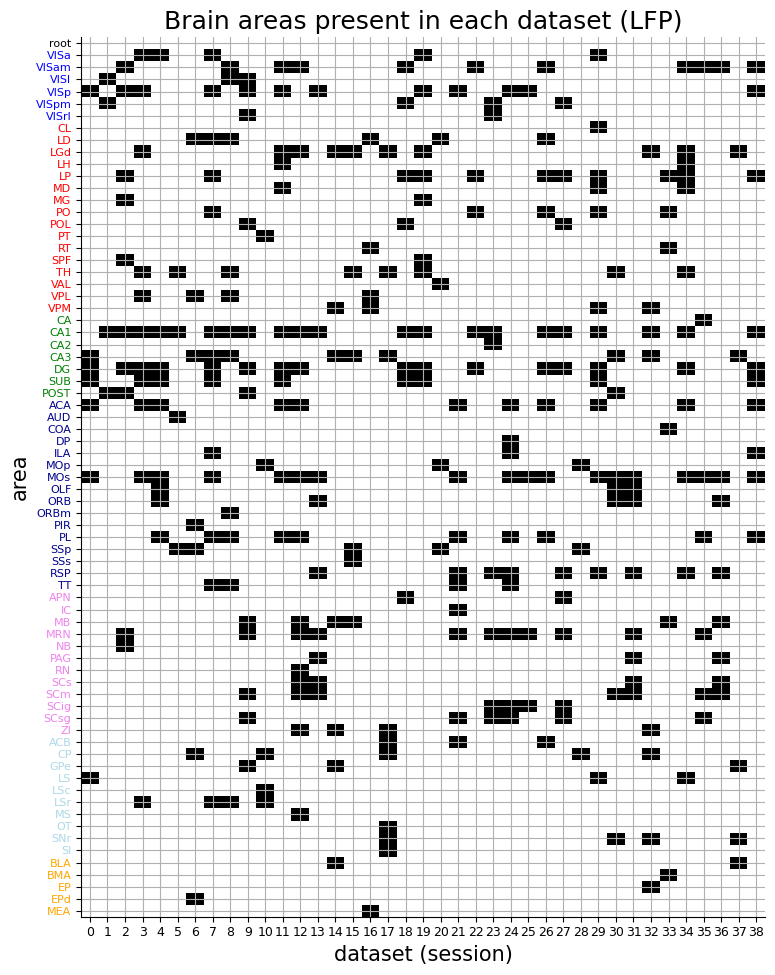

In [ ]:
# Make a plot of which brain areas are present in each dataset
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"],  # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((counter, len(dat_LFP)), dtype=bool)
for j, d in enumerate(dat_LFP):
    for area in np.unique(d['brain_area_lfp']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset (session)")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(counter), yticklabels, fontsize=8)
plt.xticks(np.arange(len(dat_LFP)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset (LFP)")
plt.grid(True)
plt.show()

In [ ]:
mouse_names = []
for session in range(39):
    mouse_name = alldat[session]['mouse_name']
    mouse_names.append(mouse_name)

dict_mouse_session = {name: [] for name in set(mouse_names)}
session = 0
for mouse_name in mouse_names:
    if mouse_name not in dict_mouse_session:
      dict_mouse_session[mouse_name] = session
    else:
      dict_mouse_session[mouse_name].append(session)
    session += 1
dict_mouse_session

{'Radnitz': [24, 25, 26, 27, 28],
 'Moniz': [18, 19, 20],
 'Richards': [29, 30, 31, 32, 33],
 'Tatum': [34, 35, 36, 37],
 'Cori': [0, 1, 2],
 'Theiler': [38],
 'Hench': [7, 8, 9, 10],
 'Lederberg': [11, 12, 13, 14, 15, 16, 17],
 'Muller': [21, 22, 23],
 'Forssmann': [3, 4, 5, 6]}

### Utility functions

In [ ]:
# Create a dictionary from brain areas to regions
dict_area_region = {}
for region, brain_areas in zip(regions, brain_groups):
    # Iterate over brain areas in each group
    for area in brain_areas:
        # Assign the region to the area in the dictionary
        dict_area_region[area] = region

dict_region_color = {region: color for region, color in zip(regions, region_colors)}
dict_area_color = {area: dict_region_color[dict_area_region[area]] for area in np.concatenate(brain_groups)}

# Set color for root area
dict_area_color['root'] = 'black'
dict_area_region['root'] = 'root_region'
dict_region_color['root_region'] = 'black'


# Create a file of the area to region dictionary
import json

# Specify the file path
file_path = "dict_area_color.json"

# Open the file in write mode
with open(file_path, 'w') as file:
    json.dump(dict_area_color, file)

import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    """Butterworth bandpass filter design."""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """Apply Butterworth bandpass filter to data."""
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def apply_bandpass_filter(dat_lfp, lowcut, highcut, fs=100, order=5):
    """
    Apply Butterworth bandpass filter to dat_lfp data.

    Parameters:
        dat_lfp (numpy.ndarray): Input LFP data of shape [channels, trials, time_samples].
        lowcut (float): Lower cutoff frequency of the bandpass filter.
        highcut (float): Upper cutoff frequency of the bandpass filter.
        fs (float): Sampling frequency of the data (default is 100 Hz).
        order (int): Order of the Butterworth filter (default is 5).

    Returns:
        numpy.ndarray: Filtered LFP data with the same shape as dat_lfp.
    """
    dat_lfp_filtered = np.empty(dat_lfp.shape)
    for i in range(dat_lfp.shape[0]):  # For each channel
        for j in range(dat_lfp.shape[1]):  # For each trial
            dat_lfp_filtered[i, j, :] = butter_bandpass_filter(dat_lfp[i, j, :], lowcut, highcut, fs, order=order)
    return dat_lfp_filtered

# Define a function to calculate the LFP latency
def calculate_lfp_latency(lfp_region, event_onset_bin, threshold_factor):
    bin_size = 10
    response_onset_latencies = []
    peak_response_latencies = []

    for trial in range(lfp_region.shape[0]):
        lfp = lfp_region[trial]
    # Calculate mean and std of baseline across trials before the onset of event
        baseline_mean = np.mean(lfp[:event_onset_bin])
        baseline_std = np.std(lfp[:event_onset_bin])
        lfp_region_baseline_corrected = lfp - baseline_mean
        # Detect response onset
        threshold = threshold_factor * baseline_std
        response_onset_bin = np.argmax(np.abs(lfp_region_baseline_corrected[event_onset_bin:]) > threshold) + event_onset_bin

        # Compute response onset latency
        response_onset_latency = (response_onset_bin - event_onset_bin) * bin_size
        response_onset_latencies.append(response_onset_latency)

        # Detect peak response
        peak_response_time = np.argmax(np.abs(lfp_region_baseline_corrected[event_onset_bin:])) + event_onset_bin

        # Compute peak response latency
        peak_response_latency = (peak_response_time - event_onset_bin) * bin_size
        peak_response_latencies.append(peak_response_latency)


    return response_onset_latencies

def mean_absolute_deviation(data):
    # Calculate the mean of the data
    mean_data = np.mean(data)

    # Calculate the absolute differences between each data point and the mean
    abs_diff = np.abs(data - mean_data)

    # Calculate the Mean Absolute Deviation (MAD)
    mad = np.mean(abs_diff)

    return mad


def calculate_vrl(signal, baseline_duration=100, stimulus_duration=350, alpha=0.05, min_duration=20):
    """
    Calculate Visual Response Latency (VRL) using t-test between signal and baseline.

    Parameters:
        signal (numpy array): The time-series signal data.
        baseline_duration (int): Duration of the baseline period in milliseconds.
        stimulus_duration (int): Duration of the stimulus presentation in milliseconds.
        alpha (float): The significance level for the t-test (default is 0.05).
        min_duration (int): Minimum duration (in milliseconds) for which the signal
                            must be significantly different from baseline to be considered VRL.

    Returns:
        vrl (int): The Visual Response Latency in milliseconds.
    """
    num_points = signal.shape[0]
    vrl = None

    baseline_start = 0
    baseline_end = baseline_duration

    for i in range(baseline_duration, num_points - min_duration):
        baseline_mean = np.mean(signal[baseline_start:baseline_end])
        t_stat, p_value = stats.ttest_ind(signal[baseline_start:baseline_end], signal[i:i+min_duration], equal_var=False)

        if p_value < alpha:
            significant_duration = 0
            for j in range(i, num_points - min_duration):
                t_stat, p_value = stats.ttest_ind(signal[baseline_start:baseline_end], signal[j:j+min_duration], equal_var=False)
                if p_value < alpha:
                    significant_duration += 1
                else:
                    break

            if significant_duration >= min_duration:
                vrl = i
                break

    return vrl

from collections import defaultdict

def merge_and_average(list_of_dicts):
    merged_dict = defaultdict(list)

    for dictionary in list_of_dicts:
        for key, value in dictionary.items():
            merged_dict[key].append(value)

    averaged_dict = {}
    for key, values in merged_dict.items():
        averaged_dict[key] = sum(values) / len(values)

    return averaged_dict


## Pipeline for pathways alignment
ipsilateral condition, correct outcome trial


### Granger Causality function

In [ ]:
def Granger_causality_direction(session, onset_time = 500, outcome_trial='correct', threshold=0):
    # Load the data for LFP and spikes
    dat_lfp = dat_LFP[session]
    dat_spks = alldat[session]

    # Event onset
    onset_bin = onset_time // 10

    # Filter trials for ipsilateral condition (right contrast == 0)
    ipsilateral_trials = dat_spks['contrast_right'] == 0

    # Filter trials for left contrast > 0
    left_contrast_trials = dat_spks['contrast_left'] > 0

    if outcome_trial == 'correct':
        # Filter for correct responses
        correct_trials = dat_spks['response'] == 1
    elif outcome_trial == 'miss':
        correct_trials = dat_spks['response'] == 0

    # Combine all filtering conditions to get the final condition for analysis
    conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)

    # Define the condition for the analysis
    ipsilateral_indices = np.where(conditions)[0]

    # Get all pairs of areas including permutations (A -> B and B -> A)
    areas = dat_lfp['brain_area_lfp']
    pairs_perm = list(permutations(areas, 2))

    # Create an ordered dictionary of brain areas and corresponding indices
    area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

    # Initialize a dictionary to store the results
    results_all_pairs_perm = {}

    # Calculate the number of tests for Bonferroni correction
    num_tests = len(pairs_perm) * len(ipsilateral_indices)

    # Loop over all pairs
    for pair in pairs_perm:
        # Get the indices of the areas in the pair using the area_indices dictionary
        index1 = area_indices[pair[0]]
        index2 = area_indices[pair[1]]

        # Initialize lists to store the p-values for each trial
        p_values_1_to_2 = []

        # Loop over all trials in the ipsilateral condition
        for trial in ipsilateral_indices:
            # Extract the LFP data for the trial from the onset_bin to the final time point
            lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
            lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]

            # Determine the optimal lag length with Akaike Information Criterion
            model = VAR(np.vstack([lfp1_trial, lfp2_trial]).T)
            lag_order_results = model.select_order(trend='n')
            lag_order = lag_order_results.aic

            # Perform the Granger causality test
            data = np.vstack([lfp1_trial, lfp2_trial]).T
            results_1_to_2 = grangercausalitytests(data, lag_order, verbose=False)

            # Extract the p-values and add them to the lists
            p_values = [results_1_to_2[i+1][0]['ssr_ftest'][1] for i in range(lag_order)]
            p_values_1_to_2.append(p_values)

        # Calculate the proportion of trials where 1 Granger causes 2 at the 5% significance level
        adjusted_alpha = 0.05 / num_tests # Boferroni correction
        prop_1_causes_2 = np.mean([any(np.array(p_values) < adjusted_alpha) for p_values in p_values_1_to_2])

        # Add the results to the dictionary
        results_all_pairs_perm[pair] = prop_1_causes_2

    # # Filter the dictionary to keep only the pairs where one area Granger causes the other in a majority of the trials
    results_majority = {pair: prop for pair, prop in results_all_pairs_perm.items() if prop > threshold}

    return results_majority

### Cross-correlation function

In [ ]:
def cross_correlation_direction(session, onset_time = 500, outcome_trial='correct', threshold=0):
    # Load the data for LFP and spikes
    dat_lfp = dat_LFP[session]
    dat_spks = alldat[session]

    # Event onset
    onset_bin = onset_time // 10

    # Filter trials for ipsilateral condition (right contrast == 0)
    ipsilateral_trials = dat_spks['contrast_right'] == 0

    # Filter trials for left contrast > 0
    left_contrast_trials = dat_spks['contrast_left'] > 0

    if outcome_trial == 'correct':
        # Filter for correct responses
        correct_trials = dat_spks['response'] == 1
    elif outcome_trial == 'miss':
        correct_trials = dat_spks['response'] == 0

    # Combine all filtering conditions to get the final condition for analysis
    conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
    ipsilateral_indices = np.where(conditions)[0]

    # Get all pairs of areas including permutations (A -> B and B -> A)
    areas = dat_lfp['brain_area_lfp']
    pairs_perm = list(permutations(areas, 2))

    # Create an ordered dictionary of brain areas and corresponding indices
    area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

    # Initialize a dictionary to store the results
    results_all_pairs_perm = {}

    # Loop over all pairs
    for pair in pairs_perm:
        # Get the indices of the areas in the pair using the area_indices dictionary
        index1 = area_indices[pair[0]]
        index2 = area_indices[pair[1]]

        # Initialize lists to store the cross-correlation and lag for each trial
        cross_corr_1_to_2 = []
        lag_1_to_2 = []

        # Loop over all trials in the ipsilateral condition
        for trial in ipsilateral_indices:
            # Extract the LFP data for the trial from the onset to the final time point
            lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
            lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]


            # Compute cross-correlation
            cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
            lag = cross_corr.argmax() - (len(lfp1_trial) - 1)
            # Add the cross-correlation and lag to the lists
            cross_corr_1_to_2.append(cross_corr.max())
            lag_1_to_2.append(lag)

        # Calculate the proportion of trials where 1 is leading 2
        prop_1_leads_2 = np.mean(np.array(lag_1_to_2) > 0)

        # Calculate the average lag where 1 is leading 2
        # Handle the specific warning
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Mean of empty slice")
            warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")

            # Calculate the mean
            average_lag_1_leads_2 = np.mean(np.array(lag_1_to_2)[np.array(lag_1_to_2) > 0])

        # Add the results to the dictionary
        results_all_pairs_perm[pair] = (prop_1_leads_2, average_lag_1_leads_2)

    results_majority = {pair: (prop) for pair, (prop, avg_lag) in results_all_pairs_perm.items() if prop > threshold}
    return results_majority


### Directionality score matrix

#### Session

In [ ]:
def compute_directionality_score_for_session(session, onset_time = 500, outcome_trial='correct'):
    # Load the data for LFP and spikes
    dat_lfp = dat_LFP[session]
    dat_spks = alldat[session]

    # Event onset
    onset_bin = onset_time // 10

    # Filter trials for ipsilateral condition (right contrast == 0)
    ipsilateral_trials = dat_spks['contrast_right'] == 0

    # Filter trials for left contrast > 0
    left_contrast_trials = dat_spks['contrast_left'] > 0

    if outcome_trial == 'correct':
        # Filter for correct responses
        correct_trials = dat_spks['response'] == 1
    elif outcome_trial == 'miss':
        correct_trials = dat_spks['response'] == 0

    # Combine all filtering conditions to get the final condition for analysis
    conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
    ipsilateral_indices = np.where(conditions)[0]

    # Get all pairs of areas including permutations (A -> B and B -> A)
    areas = dat_lfp['brain_area_lfp']
    pairs_perm = list(permutations(areas, 2))

    # Create an ordered dictionary of brain areas and corresponding indices
    area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

    # Initialize a dictionary to store the results
    directionality_score_pairs = {pair: [] for pair in pairs_perm}

    # Loop over all pairs
    for pair in pairs_perm:
        # Get the indices of the areas in the pair using the area_indices dictionary
        index1 = area_indices[pair[0]]
        index2 = area_indices[pair[1]]

        # Initialize lists to store the cross-correlation and lag for each trial
        lag_1_to_2 = []

        # Loop over all trials in the ipsilateral condition
        for trial in ipsilateral_indices:
            # Extract the LFP data for the trial from the 51st to the final time point
            lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
            lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]

            # Compute cross-correlation
            cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
            lag = cross_corr.argmax() - (len(lfp1_trial) - 1)

            # Add the lag to the list
            lag_1_to_2.append(lag)

        # Calculate the number of trials where 1 is leading 2 and where 2 is leading 1
        num_1_leads_2 = np.sum(np.array(lag_1_to_2) > 0)
        num_2_leads_1 = np.sum(np.array(lag_1_to_2) < 0)

        # Calculate the directionality score
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="invalid value encountered in long_scalars")
            directionality_score = (num_1_leads_2 - num_2_leads_1) / (num_1_leads_2 + num_2_leads_1)

        directionality_score_pairs[pair].append(directionality_score)

    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", message="Mean of empty slice")
      average_directionality_score = {key: np.nanmean(values) for key, values in directionality_score_pairs.items()}
    return average_directionality_score

#### Individual

In [ ]:
def compute_directionality_score_for_mouse(mouse_name, outcome_trial='correct', onset_time=500):
    # Get the sessions for the given mouse name
    sessions = dict_mouse_session[mouse_name]

    # Initialize a dictionary to store the results
    results_directionality_score = {}

    # Loop over the sessions for the current mouse
    for session in sessions:
        # Load the data for LFP and spikes
        dat_lfp = dat_LFP[session]
        dat_spks = alldat[session]

        # Event onset
        onset_bin = onset_time // 10

        # Filter trials for ipsilateral condition (right contrast == 0)
        ipsilateral_trials = dat_spks['contrast_right'] == 0

        # Filter trials for left contrast > 0
        left_contrast_trials = dat_spks['contrast_left'] > 0

        if outcome_trial == 'correct':
            # Filter for correct responses
            correct_trials = dat_spks['response'] == 1
        elif outcome_trial == 'miss':
            correct_trials = dat_spks['response'] == 0

        # Combine all filtering conditions to get the final condition for analysis
        conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
        ipsilateral_indices = np.where(conditions)[0]

        # Get all pairs of areas including permutations (A -> B and B -> A)
        areas = dat_lfp['brain_area_lfp']
        pairs_perm = list(permutations(areas, 2))

        # Create an ordered dictionary of brain areas and corresponding indices
        area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

        # Loop over all pairs
        for pair in pairs_perm:
            # Get the indices of the areas in the pair using the area_indices dictionary
            index1 = area_indices[pair[0]]
            index2 = area_indices[pair[1]]

            # Initialize lists to store the cross-correlation and lag for each trial
            lag_1_to_2 = []

            # Loop over all trials in the ipsilateral condition
            for trial in ipsilateral_indices:
                # Extract the LFP data for the trial from the 51st to the final time point
                lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
                lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]


                # Compute cross-correlation
                cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
                lag = cross_corr.argmax() - (len(lfp1_trial) - 1)

                # Add the lag to the list
                lag_1_to_2.append(lag)

            # Calculate the number of trials where 1 is leading 2 and where 2 is leading 1
            num_1_leads_2 = np.sum(np.array(lag_1_to_2) > 0)
            num_2_leads_1 = np.sum(np.array(lag_1_to_2) < 0)

           # Calculate the directionality score
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="invalid value encountered in long_scalars")
                directionality_score = (num_1_leads_2 - num_2_leads_1) / (num_1_leads_2 + num_2_leads_1)


            # Add the results to the dictionary
            # Add the results to the dictionary
            if pair not in results_directionality_score:
              results_directionality_score[pair] = [directionality_score]
            else:
              results_directionality_score[pair].append(directionality_score)

    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", message="Mean of empty slice")
      average_directionality_score = {key: np.nanmean(values) for key, values in results_directionality_score.items()}

    return average_directionality_score


#### Population

In [ ]:
def compute_directionality_score_for_population(outcome_trial='correct', onset_time=500):
    # Initialize a dictionary to store the results
    results_directionality_score = {}

    # Loop over the sessions for the current mouse
    for session in range(39):
        # Load the data for LFP and spikes
        dat_lfp = dat_LFP[session]
        dat_spks = alldat[session]

        # Event onset
        onset_bin = onset_time // 10

        # Filter trials for ipsilateral condition (right contrast == 0)
        ipsilateral_trials = dat_spks['contrast_right'] == 0

        # Filter trials for left contrast > 0
        left_contrast_trials = dat_spks['contrast_left'] > 0

        if outcome_trial == 'correct':
            # Filter for correct responses
            correct_trials = dat_spks['response'] == 1
        elif outcome_trial == 'miss':
            correct_trials = dat_spks['response'] == 0

        # Combine all filtering conditions to get the final condition for analysis
        conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
        ipsilateral_indices = np.where(conditions)[0]
        ipsilateral_indices = np.where(conditions)[0]

        # Get all pairs of areas including permutations (A -> B and B -> A)
        areas = dat_lfp['brain_area_lfp']
        pairs_perm = list(permutations(areas, 2))

        # Create an ordered dictionary of brain areas and corresponding indices
        area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

        # Loop over all pairs
        for pair in pairs_perm:
            # Get the indices of the areas in the pair using the area_indices dictionary
            index1 = area_indices[pair[0]]
            index2 = area_indices[pair[1]]

            # Initialize lists to store the cross-correlation and lag for each trial
            lag_1_to_2 = []

            # Loop over all trials in the ipsilateral condition
            for trial in ipsilateral_indices:
                # Extract the LFP data for the trial from the 51st to the final time point
                lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
                lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]


                # Compute cross-correlation
                cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
                lag = cross_corr.argmax() - (len(lfp1_trial) - 1)

                # Add the lag to the list
                lag_1_to_2.append(lag)

            # Calculate the number of trials where 1 is leading 2 and where 2 is leading 1
            num_1_leads_2 = np.sum(np.array(lag_1_to_2) > 0)
            num_2_leads_1 = np.sum(np.array(lag_1_to_2) < 0)

           # Calculate the directionality score
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="invalid value encountered in long_scalars")
                directionality_score = (num_1_leads_2 - num_2_leads_1) / (num_1_leads_2 + num_2_leads_1)


            # Add the results to the dictionary
            if pair not in results_directionality_score:
              results_directionality_score[pair] = [directionality_score]
            else:
              results_directionality_score[pair].append(directionality_score)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Mean of empty slice")
        average_directionality_score = {key: np.nanmean(values) for key, values in results_directionality_score.items()}
    return average_directionality_score


### Plot Directionality Score Matrix

In [ ]:
def plot_directionality_score_matrix(results_directionality_score, sequence=None):
    if sequence is None:
        sequence = list(set([area for pair in results_directionality_score.keys() for area in pair]))

    # Extract the brain areas from the pairs
    areas = sequence
    # Create an empty matrix to store the directionality scores
    directionality_matrix = np.zeros((len(areas), len(areas)))

    # Fill the matrix with the directionality scores
    for i, area1 in enumerate(areas):
        for j, area2 in enumerate(areas):
            if (area1, area2) in results_directionality_score:
                directionality_matrix[i, j] = results_directionality_score[(area1, area2)]
            elif (area2, area1) in results_directionality_score:
                directionality_matrix[i, j] = -results_directionality_score[(area2, area1)]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(directionality_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(label='Directionality Score')
    plt.xticks(np.arange(len(areas)), areas)
    plt.yticks(np.arange(len(areas)), areas)
    plt.xlabel('Target')
    plt.ylabel('Source')
    plt.title('Directionality Score Matrix')
    plt.tight_layout()
    plt.show()


#### Plot for 1 session

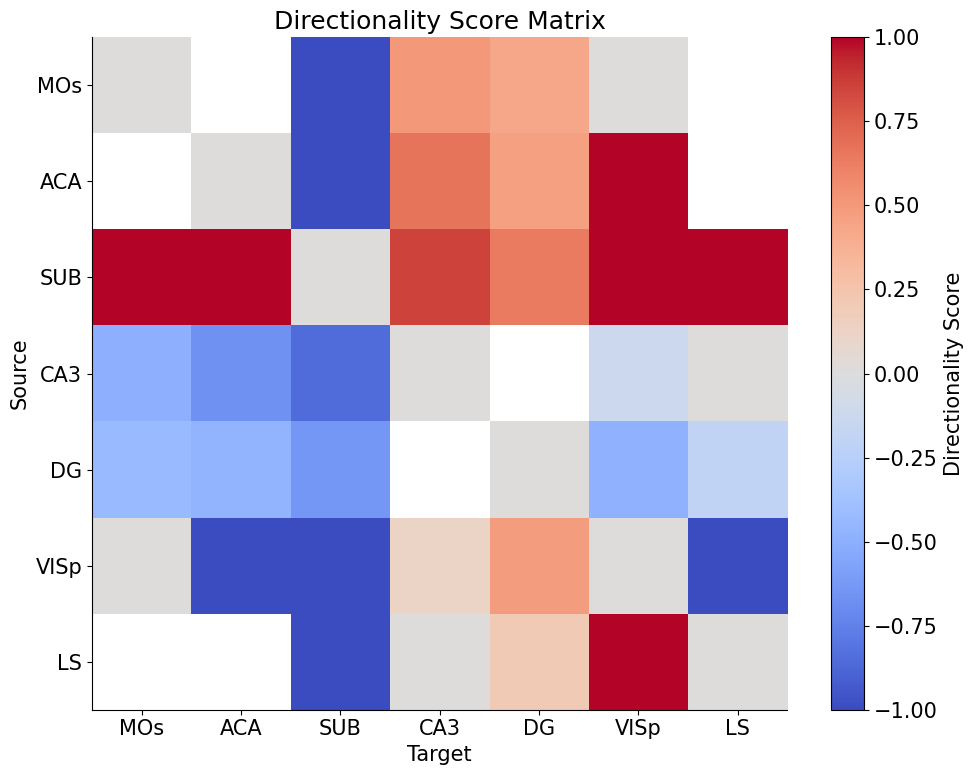

In [ ]:
# Example of session 0
sequence = ['SUB', 'ACA', 'VISp']
session0 = compute_directionality_score_for_session(0)
plot_directionality_score_matrix(session0)

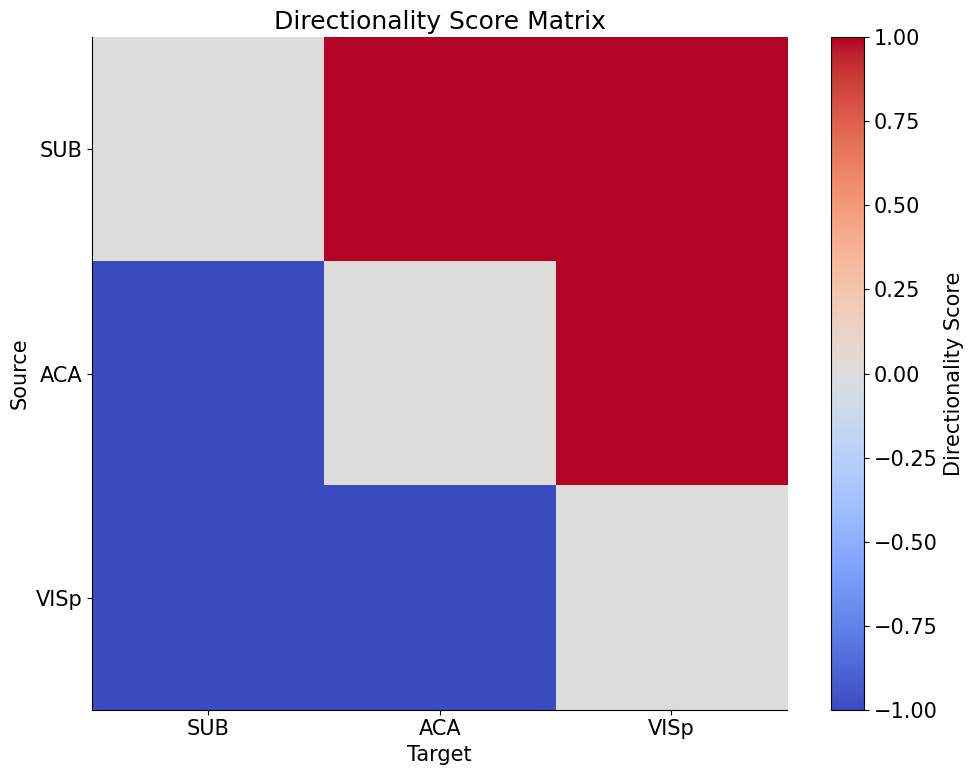

In [ ]:
plot_directionality_score_matrix(session0, sequence=sequence)

#### Plot for one mouse

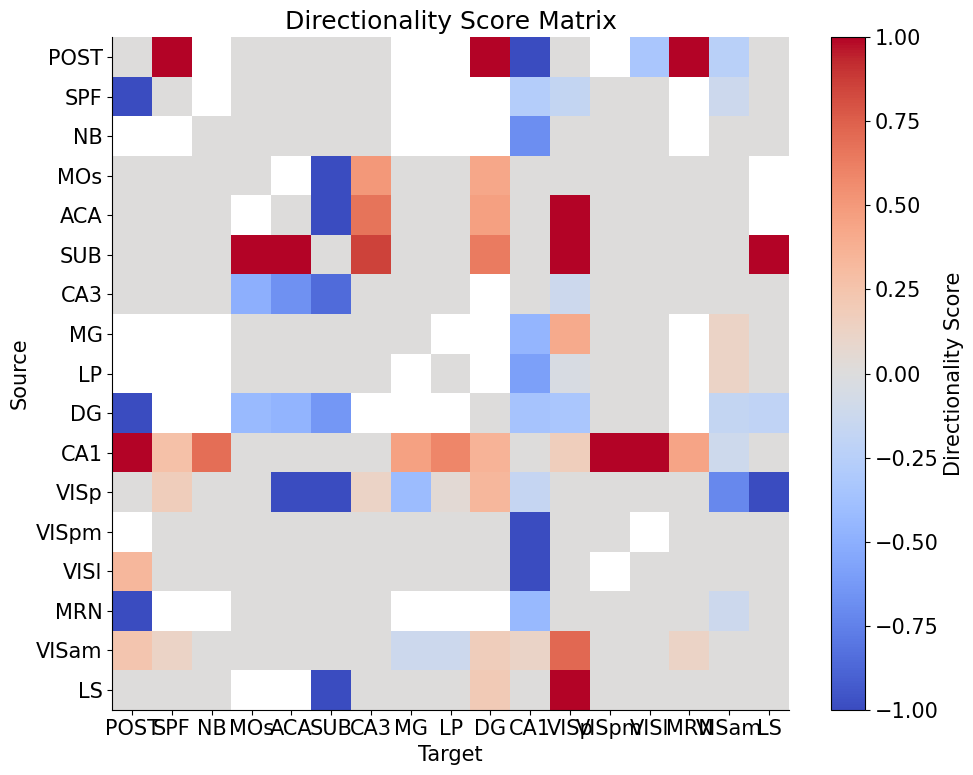

In [ ]:
# Example of Cori
mouse = compute_directionality_score_for_mouse('Cori')
plot_directionality_score_matrix(mouse)

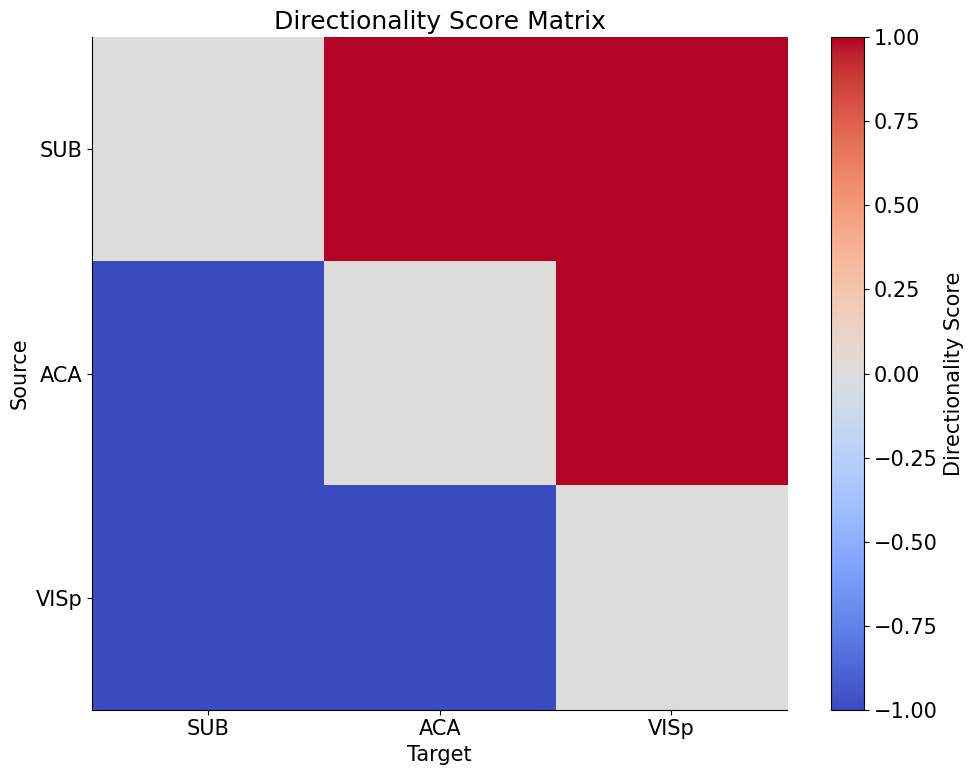

In [ ]:
# Example of Cori
mouse = compute_directionality_score_for_mouse('Cori')
plot_directionality_score_matrix(mouse, sequence)

#### Plot for the population

<ipython-input-22-7e8ba387252b>:77: RuntimeWarning: Mean of empty slice
  average_directionality_score = {key: np.nanmean(values) for key, values in results_directionality_score.items()}


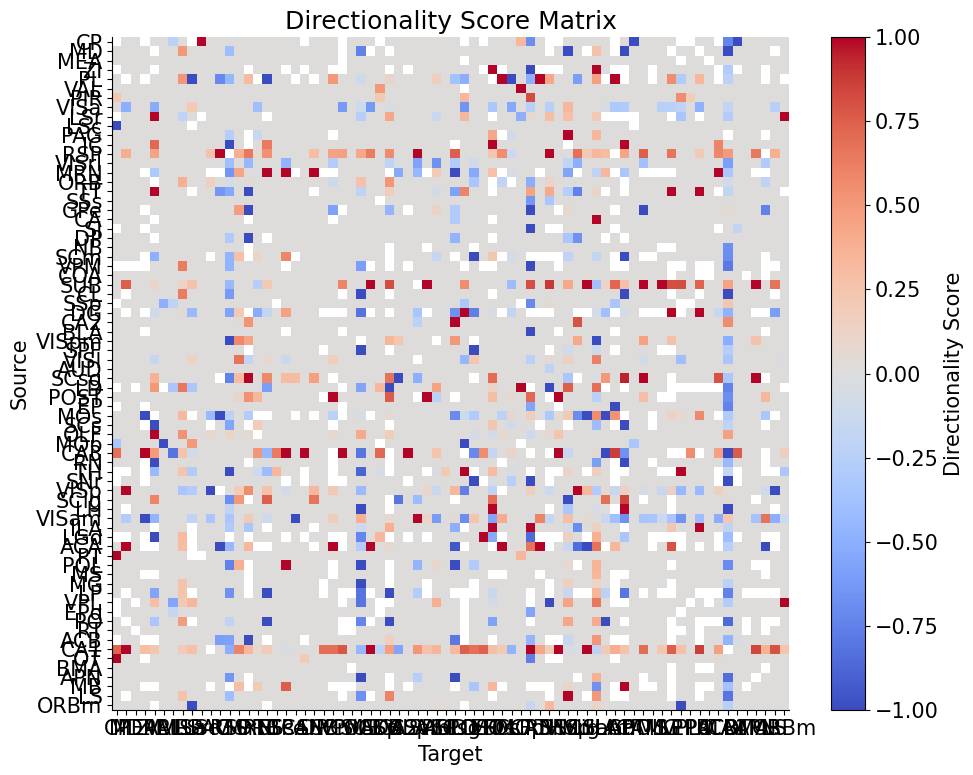

In [ ]:
# Example of population
population_directions = compute_directionality_score_for_population()
plot_directionality_score_matrix(population_directions)

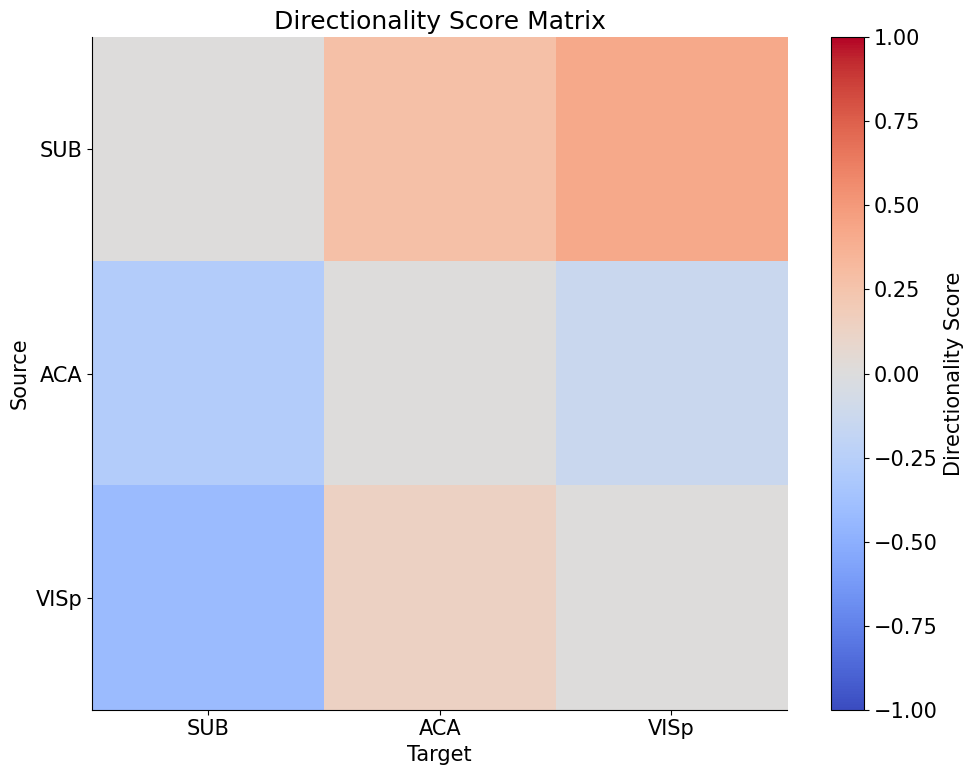

In [ ]:
# Example of population
population_directions = compute_directionality_score_for_population()
plot_directionality_score_matrix(population_directions, sequence=sequence)

### Align pathways from directions function

In [ ]:
def find_paths_exceeding_threshold(graph, path_threshold, edge_threshold):
    def dfs_path(current_node, current_weight, current_path, all_paths):
        if current_weight >= path_threshold:
            all_paths.append((current_path, current_weight))

        for (start, end), weight in graph.items():
            if start == current_node and weight >= edge_threshold and end not in current_path:
                dfs_path(end, current_weight + weight, current_path + [end], all_paths)

    all_paths = []
    nodes = set(node for edge in graph for node in edge)

    for start_node in nodes:
        dfs_path(start_node, 0, [start_node], all_paths)

    return all_paths

# Example usage:
path_threshold_value = 1.9
edge_threshold_value = 0.4
graph = compute_directionality_score_for_session(0)
all_paths_exceeding_threshold = find_paths_exceeding_threshold(graph, path_threshold=path_threshold_value, edge_threshold=edge_threshold_value)

print(f"All paths exceeding the path threshold of {path_threshold_value} and edge threshold of {edge_threshold_value}:")
for path, weight_sum in all_paths_exceeding_threshold:
    print(f"{path}: {weight_sum}")


All paths exceeding the path threshold of 1.9 and edge threshold of 0.4:
['SUB', 'ACA', 'VISp']: 2.0
['SUB', 'ACA', 'VISp', 'DG']: 2.4838709677419355
['SUB', 'LS', 'VISp']: 2.0
['SUB', 'LS', 'VISp', 'DG']: 2.4838709677419355


### Plot the network for a pathway

In [ ]:
def plot_network(filtered_sequence_direction):
    # Define the data
    data = filtered_sequence_direction
    # Filter out negative pairs and find the range of weights
    positive_data = {}
    min_weight = float('inf')
    max_weight = float('-inf')

    for key, value in data.items():
        if value >= 0:
            positive_data[key] = value
            min_weight = min(min_weight, value)
            max_weight = max(max_weight, value)

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges to the graph
    for pair, weight in positive_data.items():
        G.add_edge(pair[0], pair[1], weight=weight)

    # Create a color map for the edges
    color_map = plt.get_cmap('YlOrRd')
    edge_colors = [color_map(weight) for _, _, weight in G.edges(data='weight')]

    # Plot the graph
    fig, ax = plt.subplots(figsize=(8, 6))

    # Use the shell layout
    shell_layout = [list(G.nodes())]  # place all nodes in the same shell
    pos = nx.shell_layout(G, shell_layout)

    nx.draw(G, pos, with_labels=True, edge_color=edge_colors, width=2, arrows=True, node_color='skyblue', node_size=2000, ax=ax)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin = min_weight, vmax=max_weight))
    sm.set_array([])
    fig.colorbar(sm, orientation="vertical")

    plt.title('Network Graph')
    plt.show()


### Distribution of CCG peak time lag

The session 1 does not contain the full areas in the sequence ['SUB', 'ACA', 'VISp']


/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2093: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


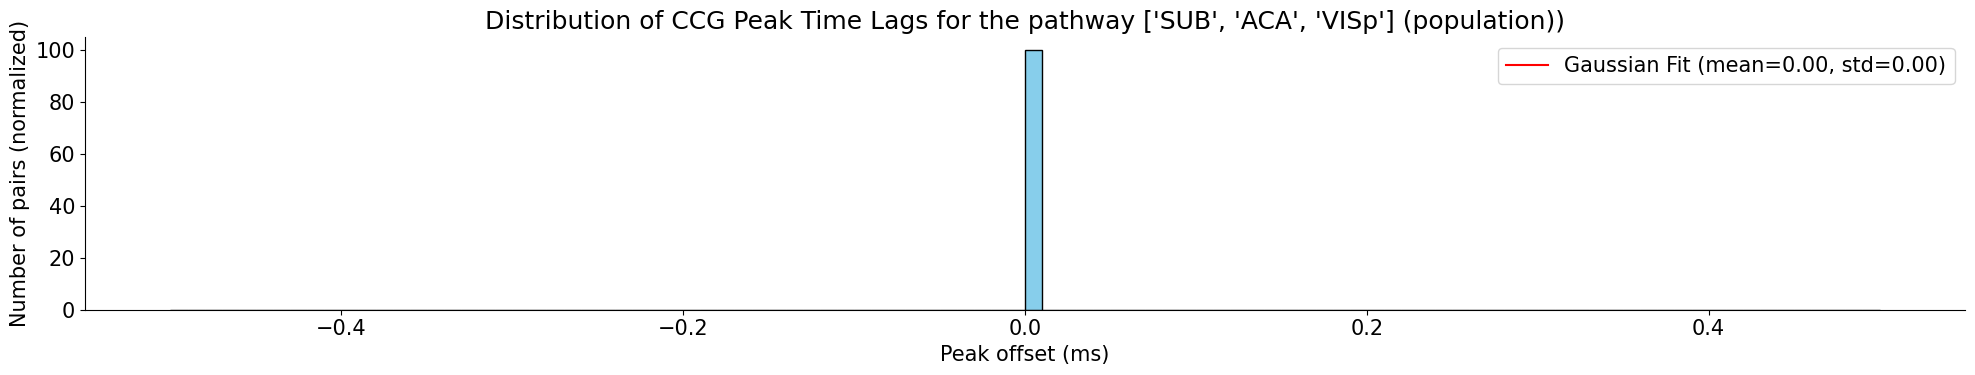

In [ ]:
def plot_CCG_peak_for_individual_pathway(mouse_name='Cori',outcome_trial='correct', onset_time=500, sequence=['SUB', 'ACA', 'VISp']):
    time_lags = []
    sessions = dict_mouse_session[mouse_name]
    # Loop over the sessions for the current mouse
    for session in sessions:
        # Load the data for LFP and spikes
        dat_lfp = dat_LFP[session]
        dat_spks = alldat[session]

        # Event onset
        onset_bin = onset_time // 10

        # Filter trials for ipsilateral condition (right contrast == 0)
        ipsilateral_trials = dat_spks['contrast_right'] == 0

        # Filter trials for left contrast > 0
        left_contrast_trials = dat_spks['contrast_left'] > 0

        if outcome_trial == 'correct':
            # Filter for correct responses
            correct_trials = dat_spks['response'] == 1
        elif outcome_trial == 'miss':
            correct_trials = dat_spks['response'] == 0

        # Combine all filtering conditions to get the final condition for analysis
        conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
        ipsilateral_indices = np.where(conditions)[0]

        # Filter for brain areas available in the data
        areas = [area for area in sequence if area in dat_lfp['brain_area_lfp']]
        if len(areas) != len(sequence):
          print(f"The session {session} does not contain the full areas in the sequence {sequence}")
          break
        # Create an ordered dictionary of brain areas and corresponding indices
        area_indices = OrderedDict((area, index) for index, area in enumerate(areas))
        pairs_perm = list(permutations(areas, 2))
        # Loop over all pairs
        for pair in pairs_perm:
            # Get the indices of the areas in the pair using the area_indices dictionary
            index1 = area_indices[pair[0]]
            index2 = area_indices[pair[1]]

            # Loop over all trials in the ipsilateral condition
            for trial in ipsilateral_indices:
                # Extract the LFP data for the trial from the 51st to the final time point
                lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
                lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]

                # Compute cross-correlation and lag using scipy.signal.correlate
                cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
                lag = cross_corr.argmax() - (len(lfp1_trial) - 1)

                # Add the lag to the list
                time_lags.append(lag)

    # Convert the list of time lags for the current mouse to a numpy array
    time_lags = np.array(time_lags) * 10 # change to ms
    # Plot the histogram of time lags for the current mouse
    plt.hist(time_lags, bins=100, density=True, color='skyblue', edgecolor='black')

    # Set the title and labels for the current mouse plot
    plt.title(f'Distribution of CCG Peak Time Lags for the pathway {sequence} (population))')
    plt.xlabel('Peak offset (ms)')
    plt.ylabel('Number of pairs (normalized)')

    # Fit a Gaussian distribution to the data
    mean, std = norm.fit(time_lags)

    # Calculate the range of x values for the fitted Gaussian curve
    x_range = np.linspace(min(time_lags), max(time_lags), 100)

    # Evaluate the fitted Gaussian distribution at the given x values
    fitted_distribution = norm.pdf(x_range, loc=mean, scale=std)

    # Plot the fitted Gaussian distribution
    plt.plot(x_range, fitted_distribution, 'r-', label=f'Gaussian Fit (mean={mean:.2f}, std={std:.2f})')

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

    return time_lags

# Example usage with specified brain area sequence
sequence = ['SUB', 'ACA', 'VISp']
mouse = plot_CCG_peak_for_individual_pathway(mouse_name='Cori', onset_time=500, sequence=sequence)


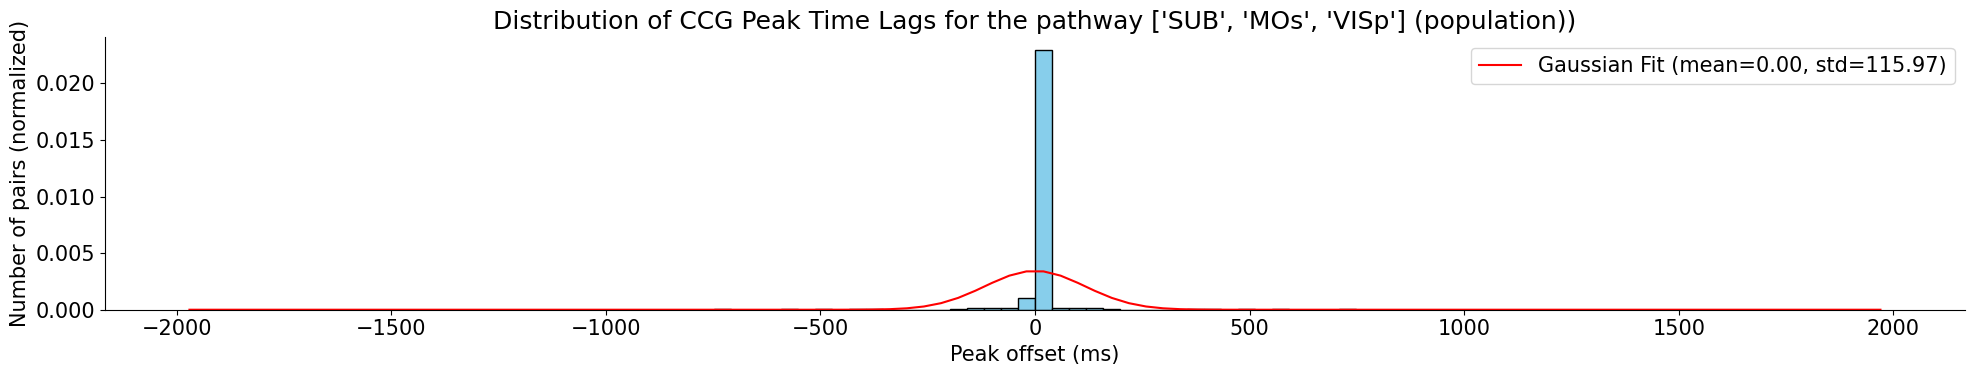

In [ ]:
def plot_CCG_peak_for_population(outcome_trial='correct', onset_time=500, sequence=None):
    time_lags = []
    # Loop over the sessions for the current mouse
    for session in range(39):
        # Load the data for LFP and spikes
        dat_lfp = dat_LFP[session]
        dat_spks = alldat[session]

        # Event onset
        onset_bin = onset_time // 10

        # Filter trials for ipsilateral condition (right contrast == 0)
        ipsilateral_trials = dat_spks['contrast_right'] == 0

        # Filter trials for left contrast > 0
        left_contrast_trials = dat_spks['contrast_left'] > 0

        if outcome_trial == 'correct':
            # Filter for correct responses
            correct_trials = dat_spks['response'] == 1
        elif outcome_trial == 'miss':
            correct_trials = dat_spks['response'] == 0

        # Combine all filtering conditions to get the final condition for analysis
        conditions = np.logical_and(correct_trials, ipsilateral_trials, left_contrast_trials)
        ipsilateral_indices = np.where(conditions)[0]

        # Filter for brain areas available in the data
        if sequence:
            areas = [area for area in sequence if area in dat_lfp['brain_area_lfp']]
        else:
            print(f"There are no complete areas in the session {session}")
            break
        pairs_perm = list(permutations(areas, 2))

        # Create an ordered dictionary of brain areas and corresponding indices
        area_indices = OrderedDict((area, index) for index, area in enumerate(areas))

        # Loop over all pairs
        for pair in pairs_perm:
            # Get the indices of the areas in the pair using the area_indices dictionary
            index1 = area_indices[pair[0]]
            index2 = area_indices[pair[1]]

            # Loop over all trials in the ipsilateral condition
            for trial in ipsilateral_indices:
                # Extract the LFP data for the trial from the 51st to the final time point
                lfp1_trial = dat_lfp['lfp'][index1, trial, onset_bin:]
                lfp2_trial = dat_lfp['lfp'][index2, trial, onset_bin:]

                # Compute cross-correlation and lag using scipy.signal.correlate
                cross_corr = correlate(lfp1_trial, lfp2_trial, mode='full', method='fft')
                lag = cross_corr.argmax() - (len(lfp1_trial) - 1)

                # Add the lag to the list
                time_lags.append(lag)

    # Convert the list of time lags for the current mouse to a numpy array
    time_lags = np.array(time_lags) * 10 # change to ms
    # Plot the histogram of time lags for the current mouse
    plt.hist(time_lags, bins=100, density=True, color='skyblue', edgecolor='black')

    # Set the title and labels for the current mouse plot
    plt.title(f'Distribution of CCG Peak Time Lags for the pathway {sequence} (population))')
    plt.xlabel('Peak offset (ms)')
    plt.ylabel('Number of pairs (normalized)')

    # Fit a Gaussian distribution to the data
    mean, std = norm.fit(time_lags)

    # Calculate the range of x values for the fitted Gaussian curve
    x_range = np.linspace(min(time_lags), max(time_lags), 100)

    # Evaluate the fitted Gaussian distribution at the given x values
    fitted_distribution = norm.pdf(x_range, loc=mean, scale=std)

    # Plot the fitted Gaussian distribution
    plt.plot(x_range, fitted_distribution, 'r-', label=f'Gaussian Fit (mean={mean:.2f}, std={std:.2f})')

    # Add a legend to the plot
    plt.legend()

    # Display the plot
    plt.show()

    return time_lags

# Example usage with specified brain area sequence
sequence = ['SUB', 'MOs', 'VISp']
time_lags = plot_CCG_peak_for_population(onset_time=500, sequence=sequence)

## Analysis for pathways

### Individual

In [ ]:
def find_pathway_individual(path_threshold_value = 3, edge_threshold_value = .7, onset = 500, trial = 'correct'):

    mouse_direction = {}
    for mouse in dict_mouse_session.keys():
      direct_list = []
      mouse_direction[mouse] = compute_directionality_score_for_mouse(mouse)

    dict_mouse_pathway = {}
    for mouse in dict_mouse_session.keys():
        print(f" ================= mouse {mouse} ========================")
        individual_connections = mouse_direction[mouse]
        print("Brain area connections: ", len(individual_connections))
        all_paths_exceeding_threshold = find_paths_exceeding_threshold(individual_connections, path_threshold_value, edge_threshold_value)
        dict_mouse_pathway[mouse] = all_paths_exceeding_threshold
        print(f"All paths exceeding the path threshold of {path_threshold_value} and edge threshold of {edge_threshold_value}:")
        for path, weight_sum in all_paths_exceeding_threshold:
            print(f"{path}: {weight_sum}")
        print("==========================================================\n")
    return dict_mouse_pathway, mouse_direction

 ================= mouse Lederberg ========================
Brain area connections:  441
All paths exceeding the path threshold of 2 and edge threshold of 0.7:
['ZI', 'VISam', 'MB']: 2.0
['ZI', 'VISam', 'MB', 'ACA']: 3.0
['ZI', 'VISam', 'MB', 'ACA', 'MD']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'MRN']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'RN']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'SCm']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'SCs']: 4.0
['ZI', 'VISam', 'MRN']: 2.0
['ZI', 'VISam', 'SCm']: 2.0
['ZI', 'VISam', 'SCs']: 2.0
['ZI', 'MOs', 'VISam']: 2.0
['ZI', 'MOs', 'VISam', 'MB']: 3.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA']: 4.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'MD']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'MRN']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'RN']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'SCm']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'SCs']: 5.0
['ZI', 'MOs', 'VISam', 'MRN']: 3.0
['ZI', 'MOs', 'VISam', 'SCm']: 3.0
['ZI', 'MOs', 'VISam', 'SCs']: 3.0
['PL', 'VISam', 'MB']: 2.0
['PL', 'VISam', 'MB

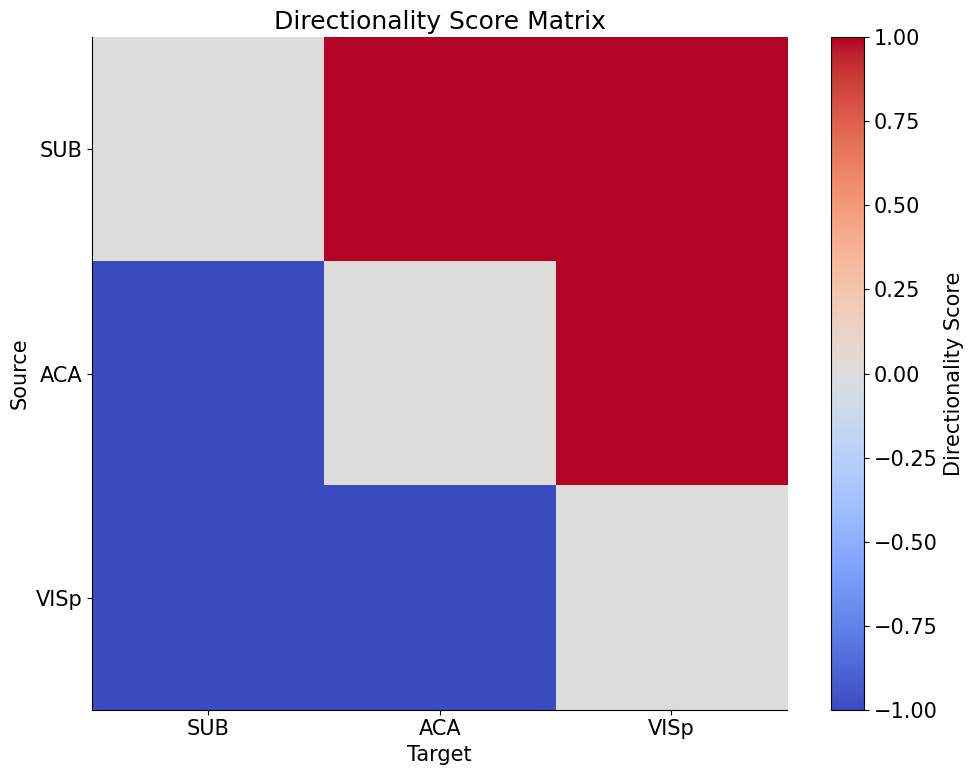

The sequence is: ['SUB', 'LS', 'VISp']


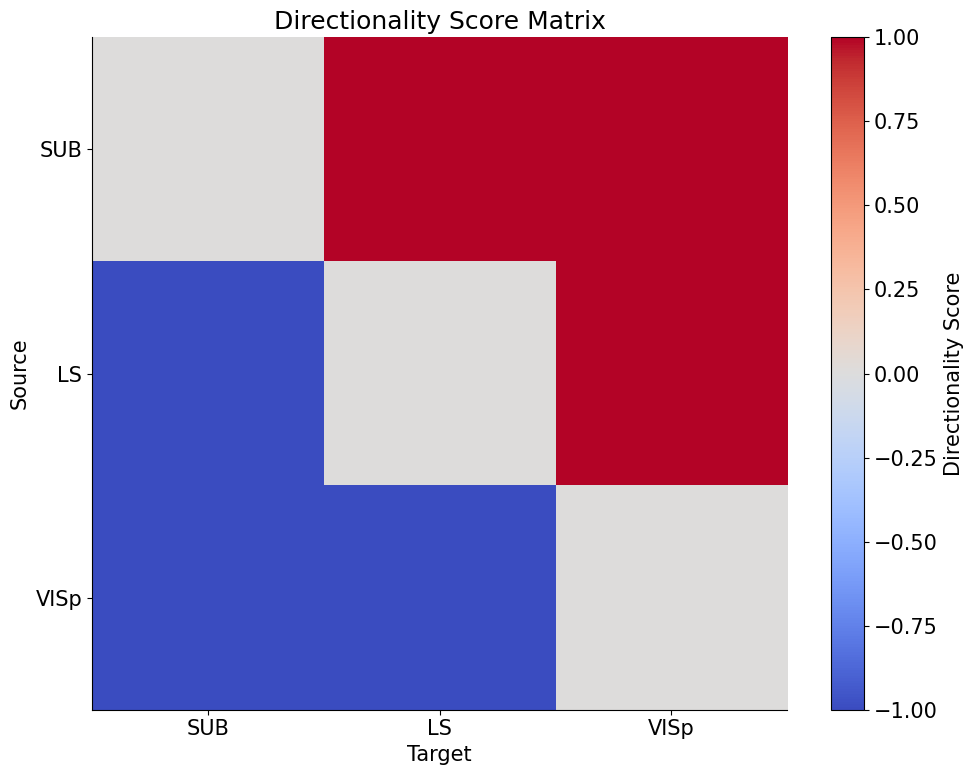

The sequence is: ['CA1', 'POST', 'DG']


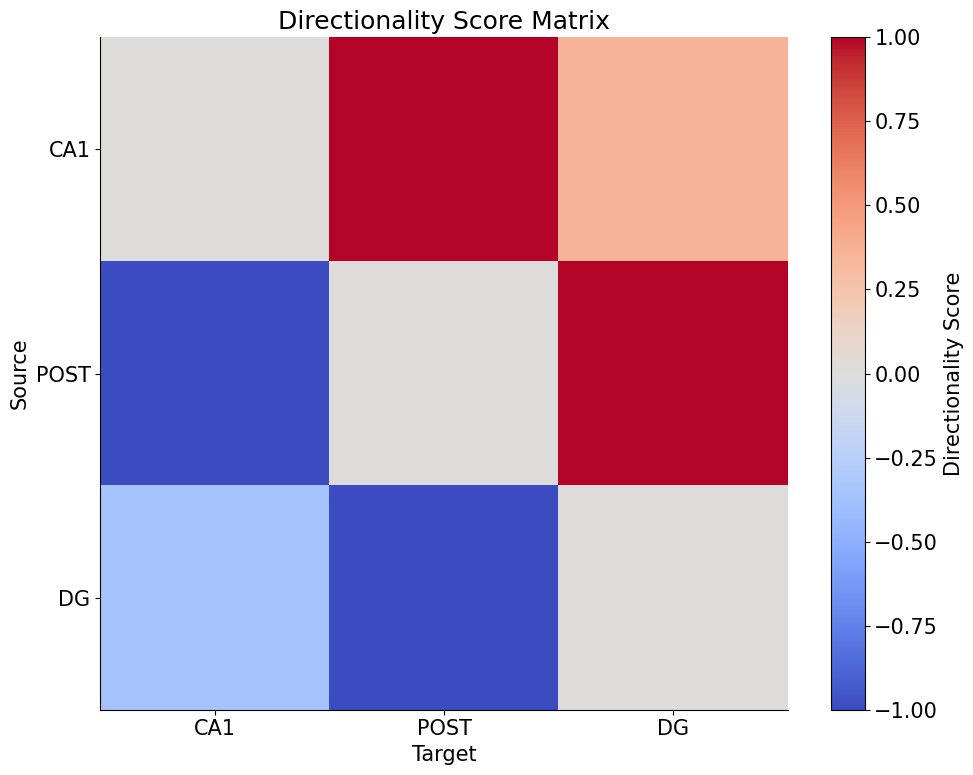

The sequence is: ['CA1', 'POST', 'SPF']


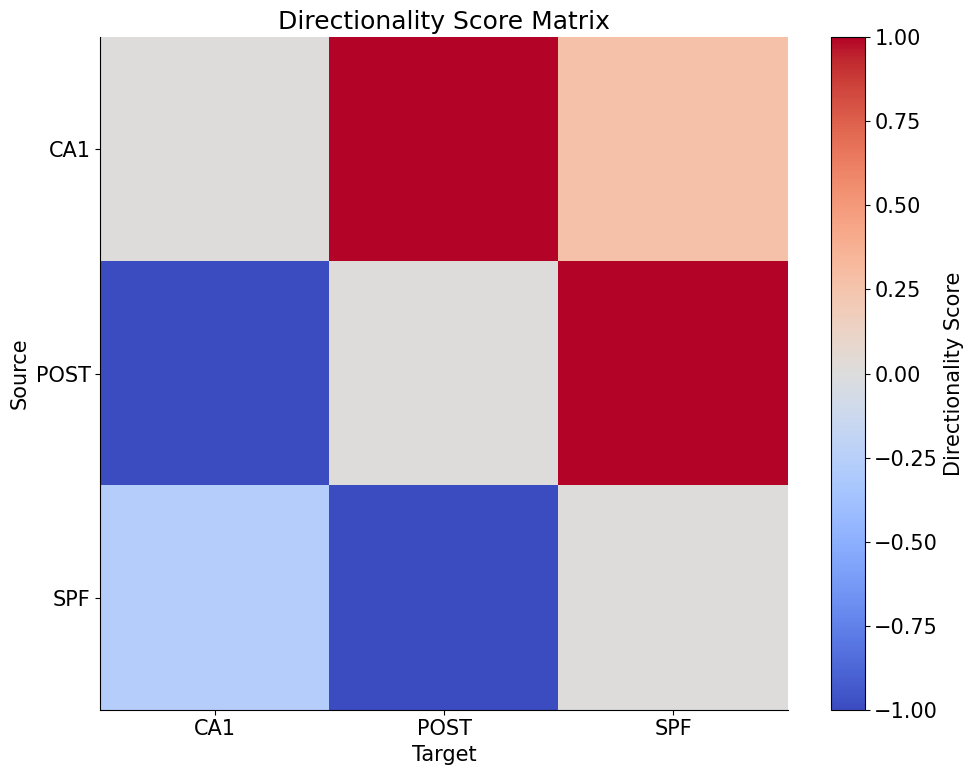

The sequence is: ['CA1', 'POST', 'MRN']


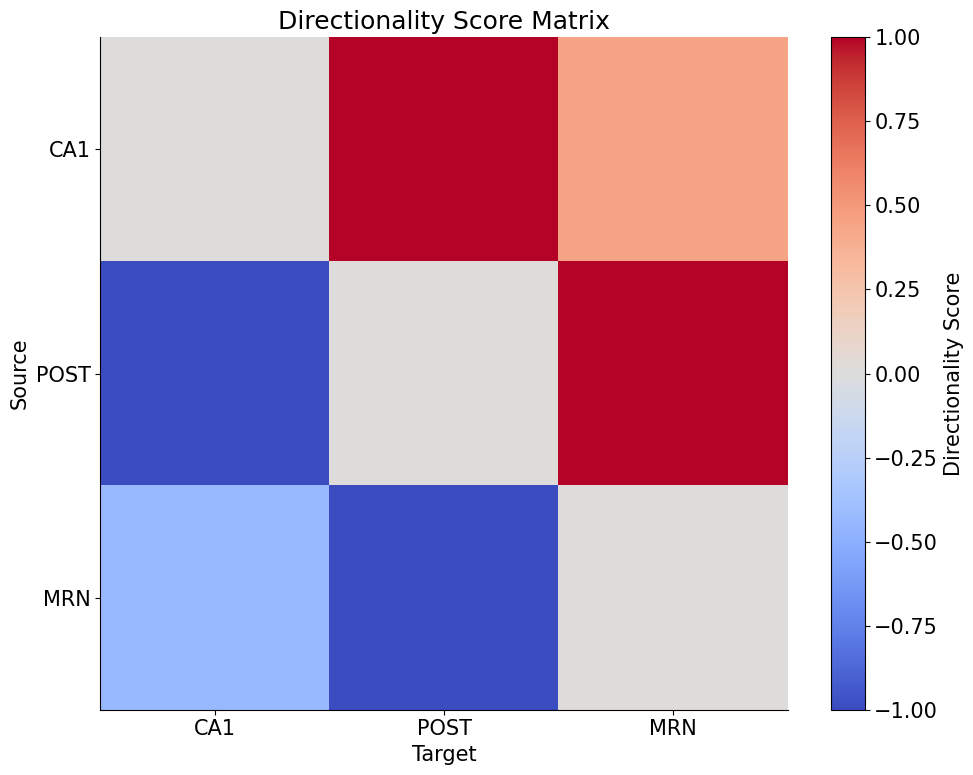

In [ ]:
# Example on one mouse
path_threshold_value = 2
edge_threshold_value = .7
onset = 500
trial = 'correct'
mouse_pathways, mouse_directions = find_pathway_individual(path_threshold_value, edge_threshold_value, onset, trial)
mouse_1_pathways = mouse_pathways['Cori']
mouse_1_directions = mouse_directions['Cori']
mouse_1_pathways

# Extract the specific pathways from pathways
brain_areas = []
for brain_areas_list, value in mouse_1_pathways:
    brain_areas.extend(brain_areas_list)
brain_areas = set(brain_areas)


# Plot the DS matrix
for k in range(len(mouse_1_pathways)):
    sequence = mouse_1_pathways[k][0]
    print("The sequence is:", sequence)
    filtered_sequence_direction = {pair: value for pair, value in mouse_1_directions.items() if all(area in sequence for area in pair)}

    plot_directionality_score_matrix(results_directionality_score=filtered_sequence_direction, sequence=sequence)

 ================= mouse Lederberg ========================
Brain area connections:  441
All paths exceeding the path threshold of 2 and edge threshold of 0.7:
['ZI', 'VISam', 'MB']: 2.0
['ZI', 'VISam', 'MB', 'ACA']: 3.0
['ZI', 'VISam', 'MB', 'ACA', 'MD']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'MRN']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'RN']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'SCm']: 4.0
['ZI', 'VISam', 'MB', 'ACA', 'SCs']: 4.0
['ZI', 'VISam', 'MRN']: 2.0
['ZI', 'VISam', 'SCm']: 2.0
['ZI', 'VISam', 'SCs']: 2.0
['ZI', 'MOs', 'VISam']: 2.0
['ZI', 'MOs', 'VISam', 'MB']: 3.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA']: 4.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'MD']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'MRN']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'RN']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'SCm']: 5.0
['ZI', 'MOs', 'VISam', 'MB', 'ACA', 'SCs']: 5.0
['ZI', 'MOs', 'VISam', 'MRN']: 3.0
['ZI', 'MOs', 'VISam', 'SCm']: 3.0
['ZI', 'MOs', 'VISam', 'SCs']: 3.0
['PL', 'VISam', 'MB']: 2.0
['PL', 'VISam', 'MB

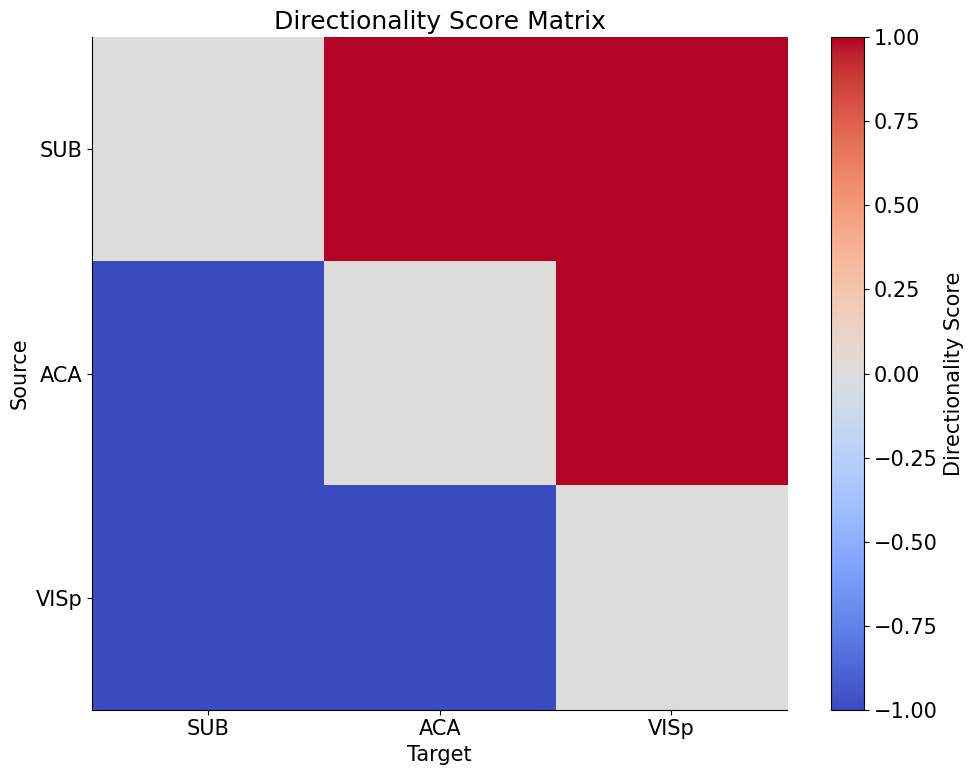

The sequence is: ['SUB', 'LS', 'VISp']


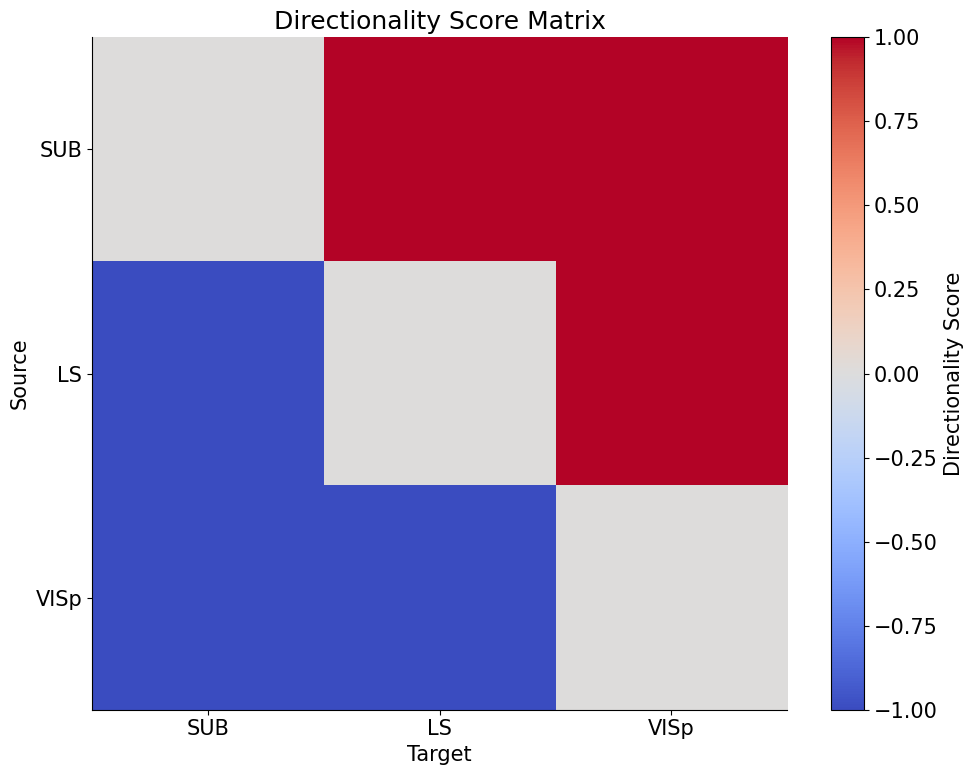

The sequence is: ['CA1', 'POST', 'DG']


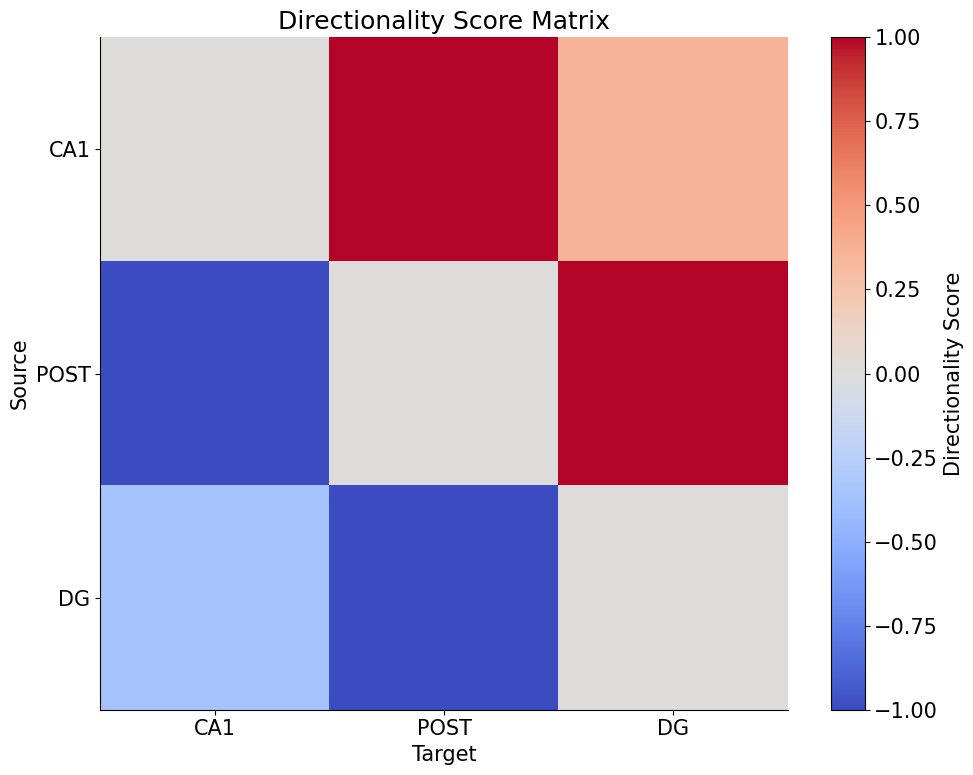

The sequence is: ['CA1', 'POST', 'SPF']


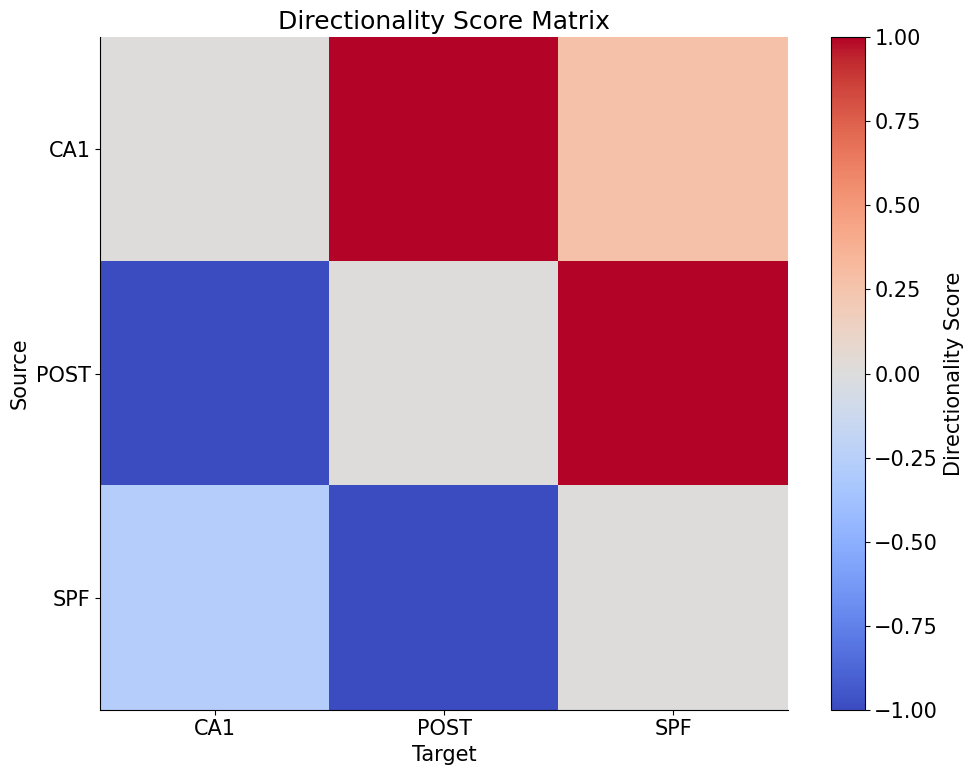

The sequence is: ['CA1', 'POST', 'MRN']


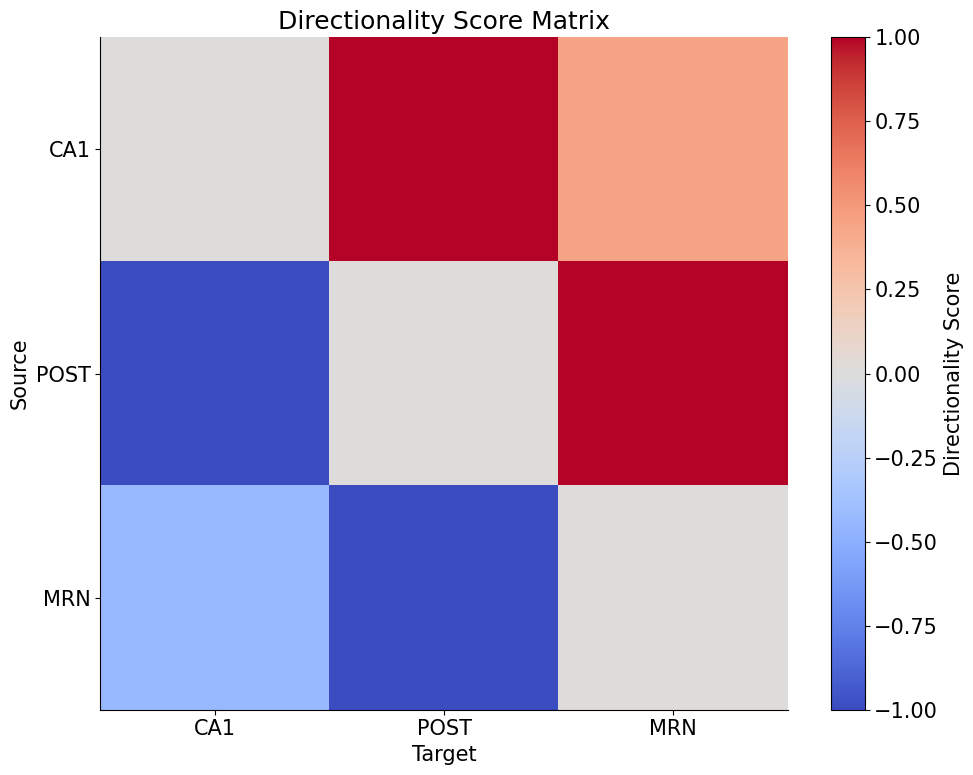

In [ ]:
# Example on one mouse
path_threshold_value = 2
edge_threshold_value = .7
onset = 500
trial = 'miss'
mouse_pathways, mouse_directions = find_pathway_individual(path_threshold_value, edge_threshold_value, onset, trial)
mouse_1_pathways = mouse_pathways['Cori']
mouse_1_directions = mouse_directions['Cori']
mouse_1_pathways

# Extract the specific pathways from pathways
brain_areas = []
for brain_areas_list, value in mouse_1_pathways:
    brain_areas.extend(brain_areas_list)
brain_areas = set(brain_areas)
# brain_areas


# Plot the DS matrix
for k in range(len(mouse_1_pathways)):
# k = 0 # the k-th pathway
    sequence = mouse_1_pathways[k][0]
    print("The sequence is:", sequence)
    filtered_sequence_direction = {pair: value for pair, value in mouse_1_directions.items() if all(area in sequence for area in pair)}

    plot_directionality_score_matrix(results_directionality_score=filtered_sequence_direction, sequence=sequence)
# directionality_score_matrix_plot()

### Population

In [ ]:
def find_pathway_population(path_threshold_value = 3, edge_threshold_value = .7, onset = 500, trial = 'correct'):
    population_direction = merge_and_average([compute_directionality_score_for_session(session, onset_time=onset, outcome_trial=trial) for session in range(39)])
    population_connections = population_direction
    print("Brain area connections: ", len(population_connections))
    all_paths_exceeding_threshold = find_paths_exceeding_threshold(population_connections, path_threshold_value, edge_threshold_value)
    print(f"All paths exceeding the path threshold of {path_threshold_value} and edge threshold of {edge_threshold_value}:")
    for path, weight_sum in all_paths_exceeding_threshold:
        print(f"{path}: {weight_sum}")
    return all_paths_exceeding_threshold, population_direction


In [ ]:
def find_pathway_population(path_threshold_value, edge_threshold_value, onset, trial, output_file):
    population_direction = compute_directionality_score_for_population(outcome_trial=trial,onset_time=onset)
    population_connections = population_direction
    result_str = "Brain area connections: " + str(len(population_connections)) + "\n"
    all_paths_exceeding_threshold = find_paths_exceeding_threshold(population_connections, path_threshold_value, edge_threshold_value)
    result_str += f"All paths exceeding the path threshold of {path_threshold_value} and edge threshold of {edge_threshold_value}:\n"
    for path, weight_sum in all_paths_exceeding_threshold:
        result_str += f"{path}: {weight_sum}\n"

    if output_file:
        with open(output_file, 'w') as file:
            file.write(result_str)

    return all_paths_exceeding_threshold, population_direction

# Example usage:
output_filename = "pathway_population_results.txt"
find_pathway_population(path_threshold_value=2, edge_threshold_value=0.5, onset=700, trial='correct', output_file=output_filename)
print("Results written to:", output_filename)


Results written to: pathway_population_results.txt


In [ ]:
def filter_paths_by_regions(file_path, filter_regions):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    paths_list = []
    is_paths_section = False
    for line in lines:
        line = line.strip()
        if not is_paths_section:
            if line.startswith("All paths exceeding the path threshold"):
                is_paths_section = True
            continue

        if line.startswith("["):
            path_str, weight = line.split(": ")
            path = eval(path_str)  # Convert the string representation of list to a list
            paths_list.append((path, float(weight)))

    filtered_paths = []
    for path, weight in paths_list:
        if all(region in filter_regions for region in path):
            filtered_paths.append((path, weight))

    return filtered_paths

# File containing the paths
file_path = "pathway_population_results.txt"

# Regions to filter
filter_regions = ['VISp', 'VISl', 'VISpm', 'VISam', 'VISrl', 'VISa', 'ACA', 'MOs', 'PL', 'CP', 'GPe', 'SNr', 'LP', 'LD', 'SCs', 'SCm', 'MRN', 'APN']

# Filter paths based on the regions
filtered_paths = filter_paths_by_regions(file_path, filter_regions)

# Print the filtered paths
for path, weight in filtered_paths:
    print(path, weight)


['VISl', 'VISam', 'VISpm', 'VISrl'] 2.205128205128205
['VISl', 'VISam', 'VISpm', 'MRN'] 2.4166666666666665
['VISl', 'VISam', 'VISpm', 'MRN', 'GPe'] 3.4166666666666665
['LD', 'VISam', 'VISpm', 'VISrl'] 2.178256146933939
['LD', 'VISam', 'VISpm', 'MRN'] 2.3897946084724007
['LD', 'VISam', 'VISpm', 'MRN', 'GPe'] 3.3897946084724007
['MOs', 'ACA', 'VISam', 'VISpm'] 2.6803729603729605
['MOs', 'ACA', 'VISam', 'VISpm', 'VISrl'] 3.218834498834499
['MOs', 'ACA', 'VISam', 'VISpm', 'MRN'] 3.4303729603729605
['MOs', 'ACA', 'VISam', 'VISpm', 'MRN', 'GPe'] 4.43037296037296
['MOs', 'ACA', 'SCs'] 2.0
['MOs', 'PL', 'SCs'] 2.0
['MOs', 'VISam', 'VISpm', 'VISrl'] 2.048870177441606
['MOs', 'VISam', 'VISpm', 'MRN'] 2.2604086389800675
['MOs', 'VISam', 'VISpm', 'MRN', 'GPe'] 3.2604086389800675
['VISam', 'VISpm', 'MRN', 'GPe'] 2.75
['ACA', 'VISam', 'VISpm', 'VISrl'] 2.218834498834499
['ACA', 'VISam', 'VISpm', 'MRN'] 2.4303729603729605
['ACA', 'VISam', 'VISpm', 'MRN', 'GPe'] 3.4303729603729605


In [ ]:
population_directions = compute_directionality_score_for_population(onset_time=700, outcome_trial='correct')

The sequence is: ['VISl', 'VISam', 'VISpm', 'VISrl']


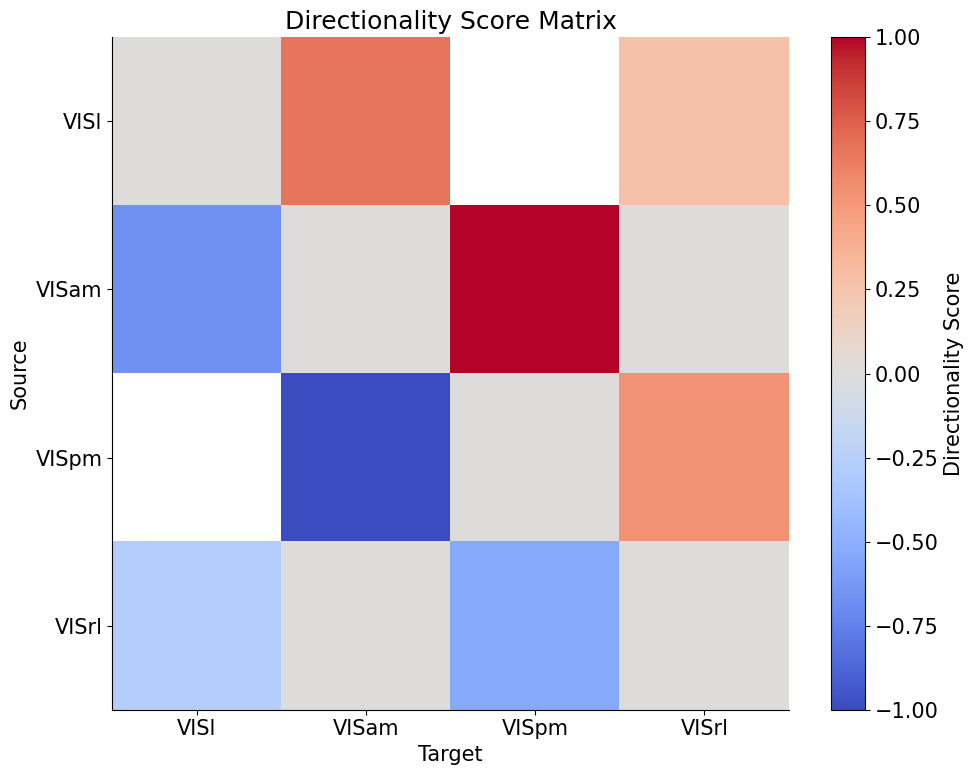

<ipython-input-78-e931bd5046a2>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, orientation="vertical")


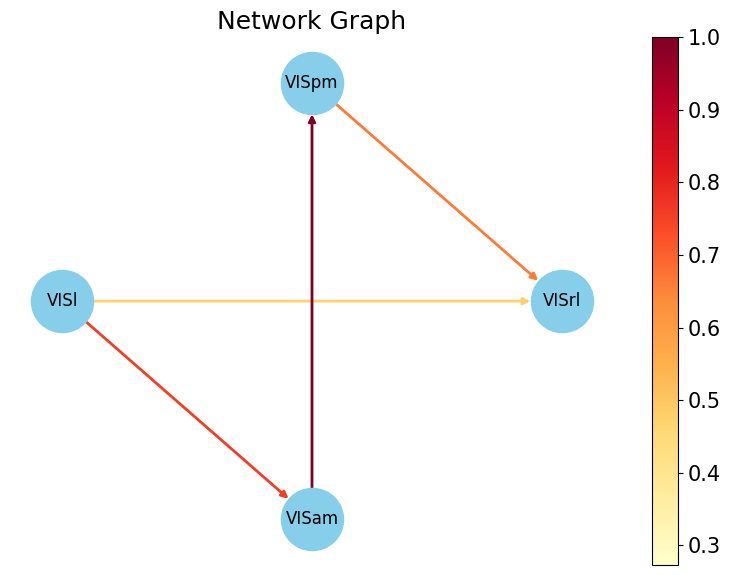

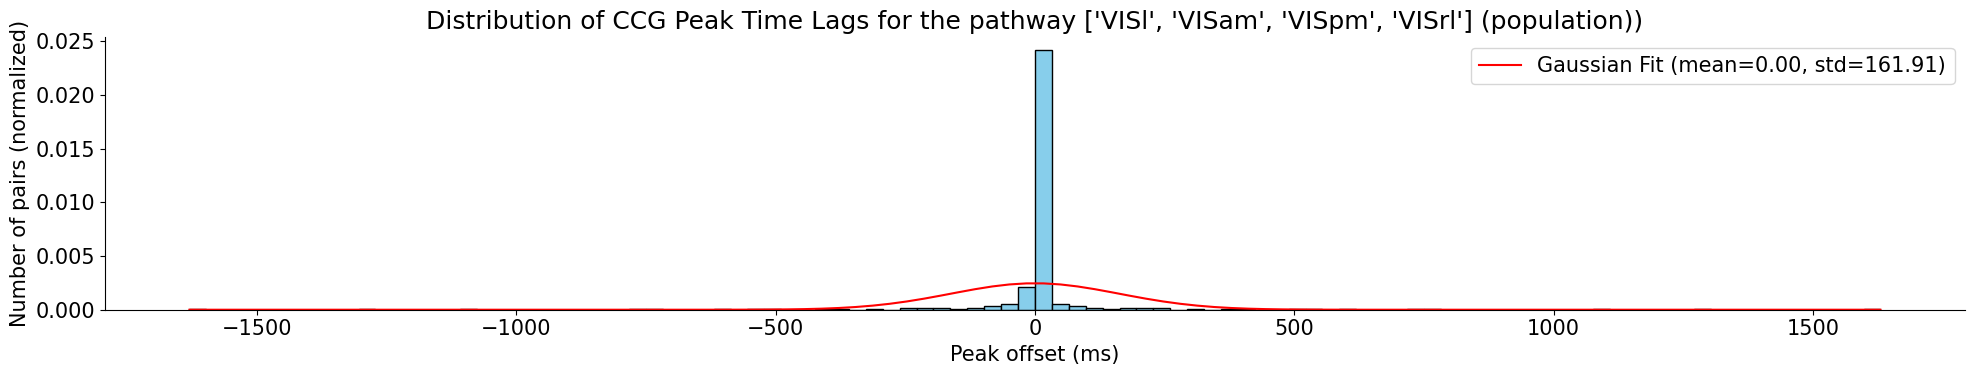

The sequence is: ['VISl', 'VISam', 'VISpm', 'MRN']


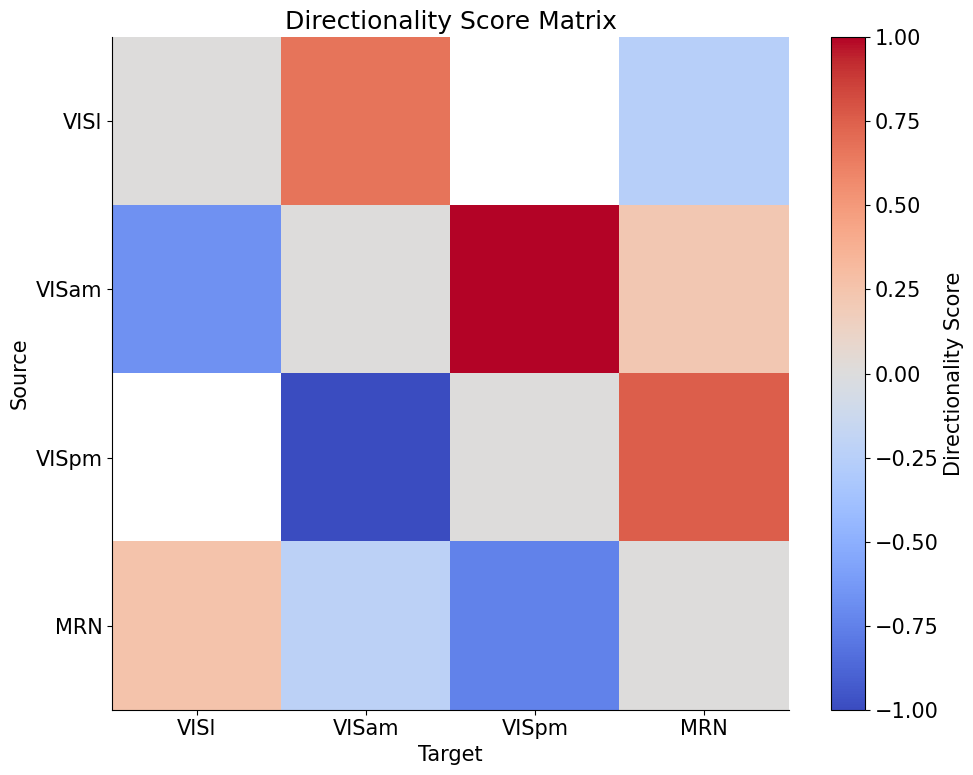

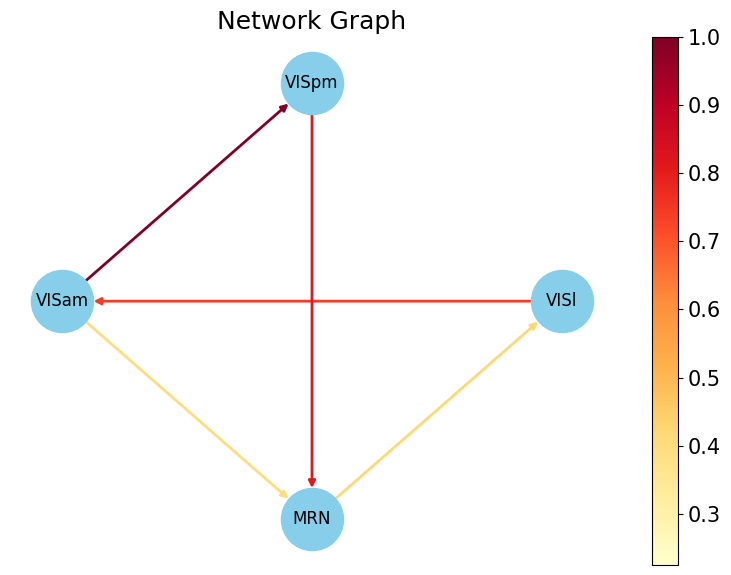

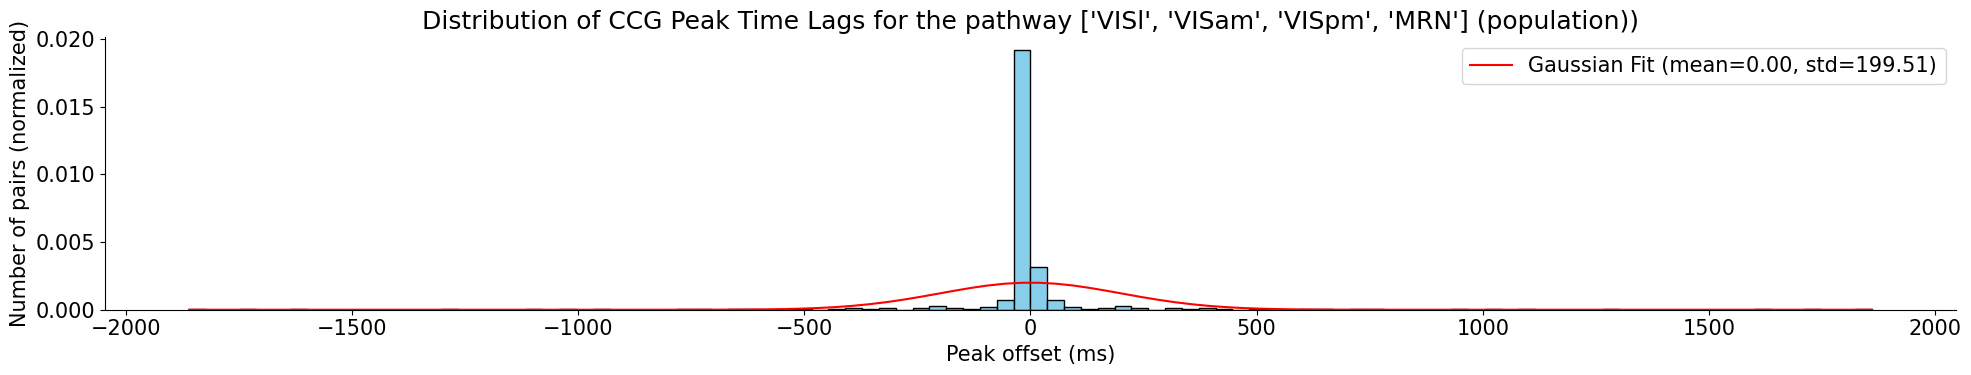

The sequence is: ['VISl', 'VISam', 'VISpm', 'MRN', 'GPe']


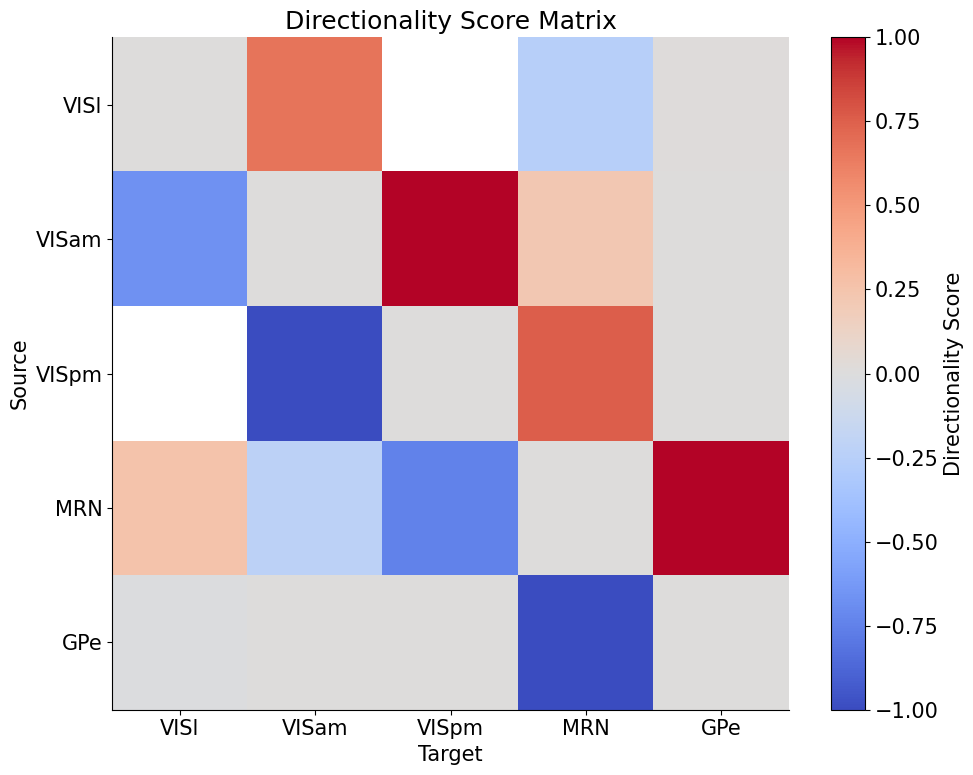

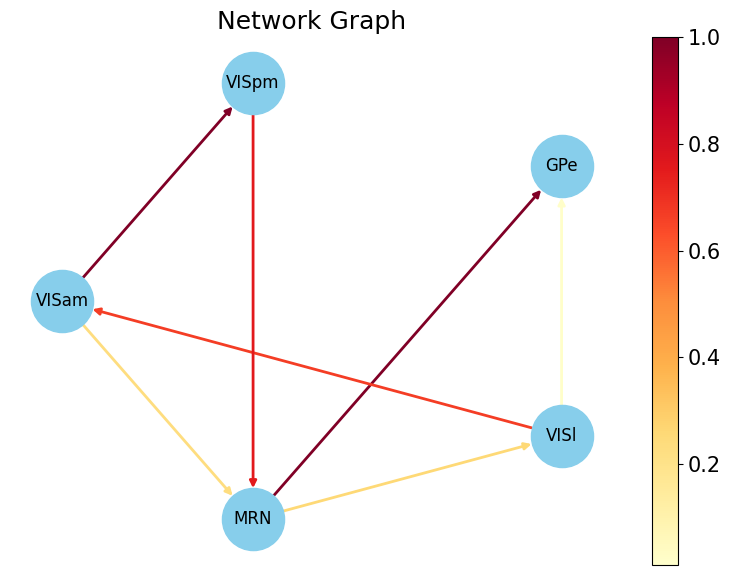

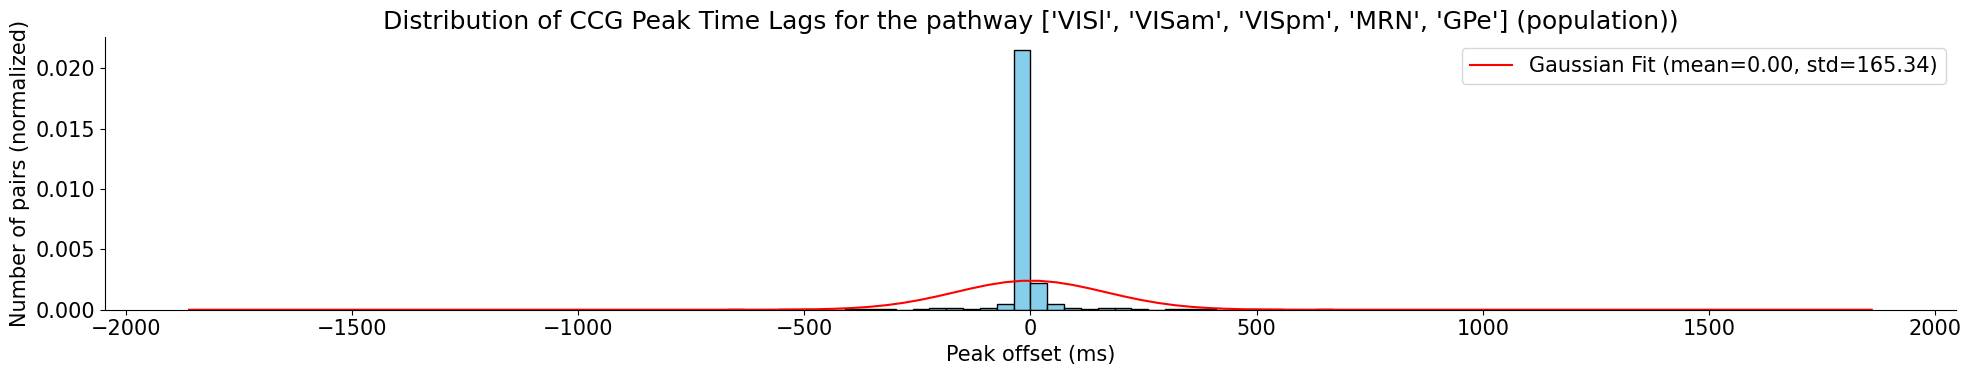

The sequence is: ['LD', 'VISam', 'VISpm', 'VISrl']


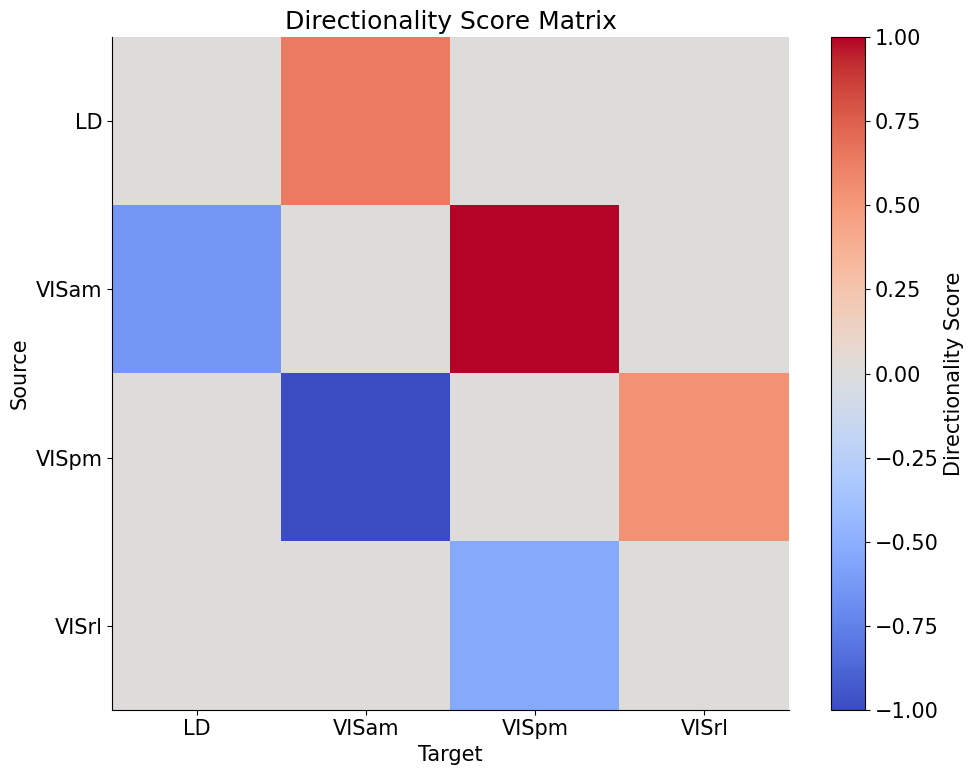

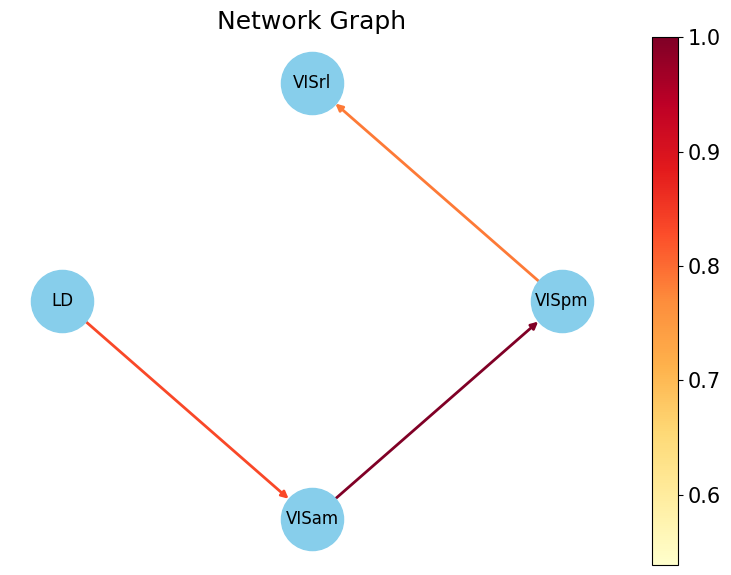

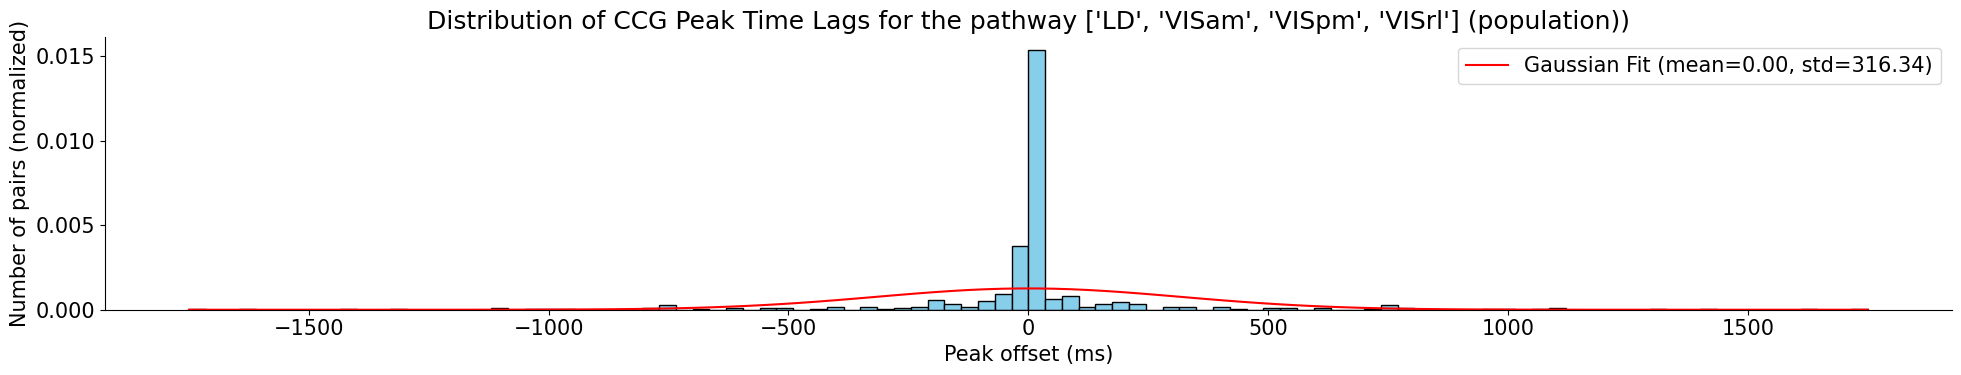

The sequence is: ['LD', 'VISam', 'VISpm', 'MRN']


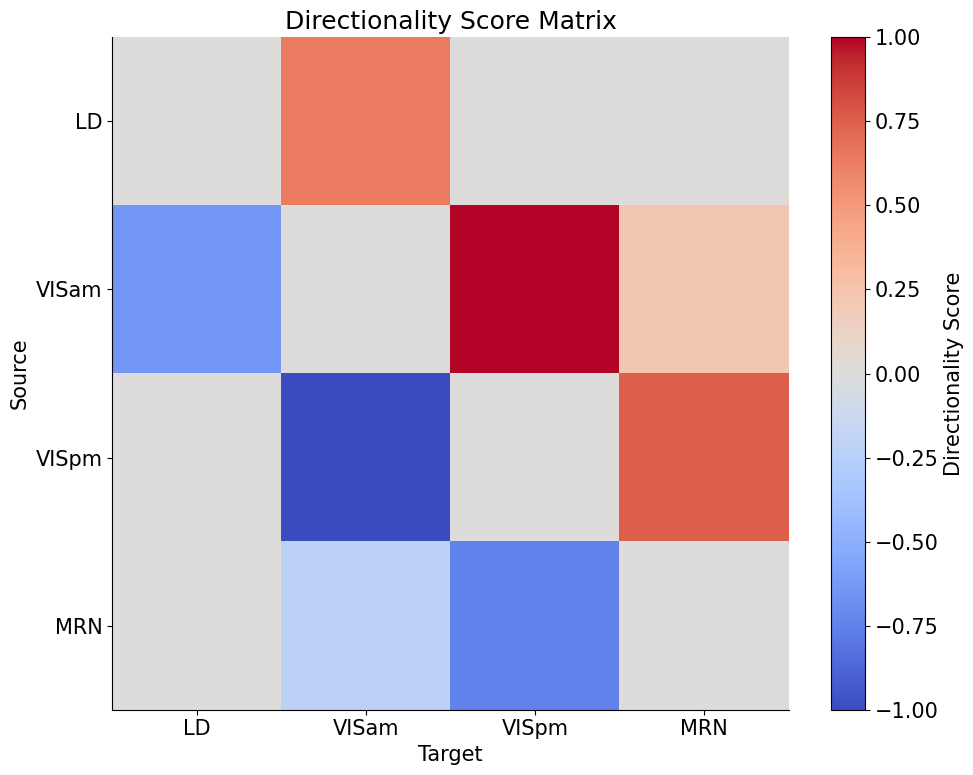

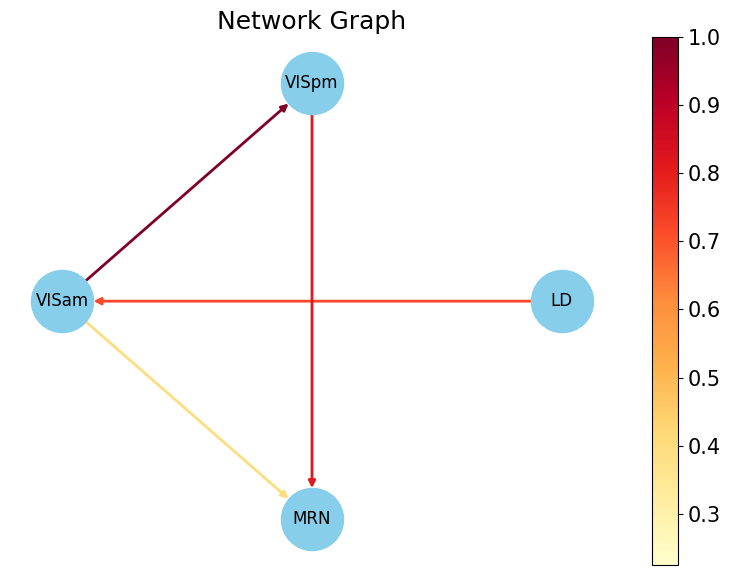

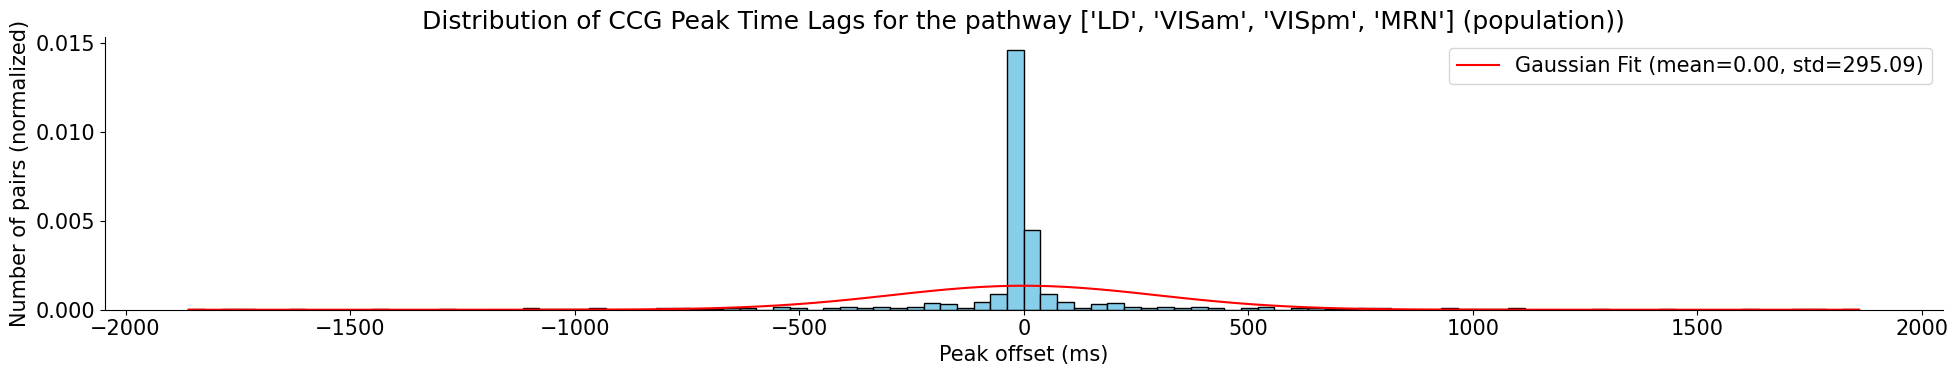

The sequence is: ['LD', 'VISam', 'VISpm', 'MRN', 'GPe']


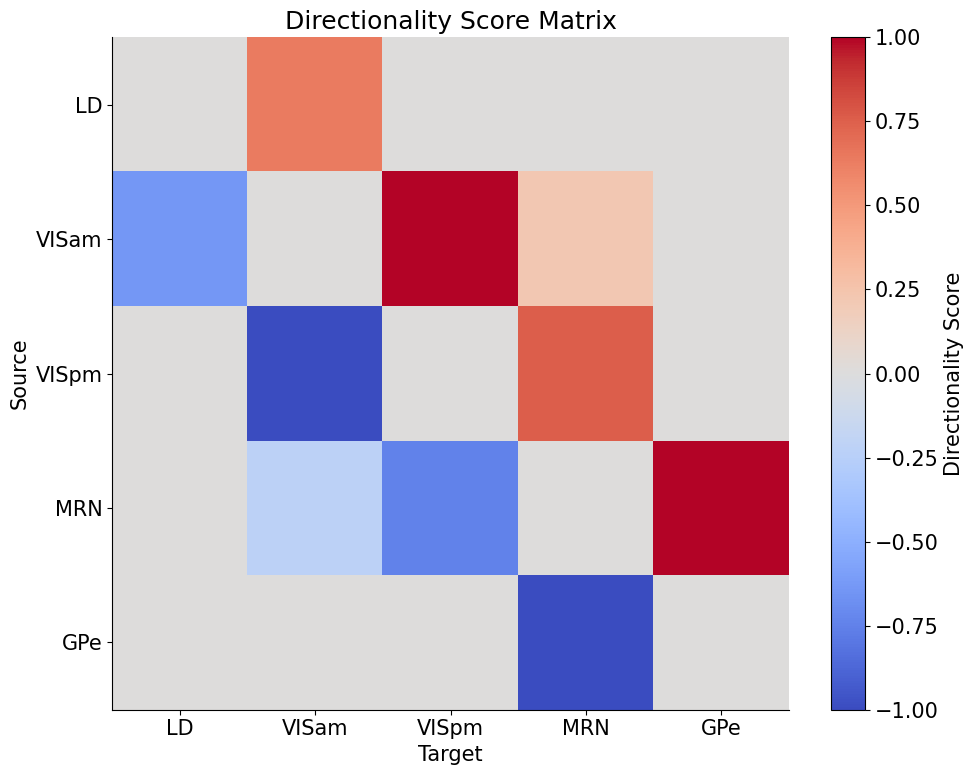

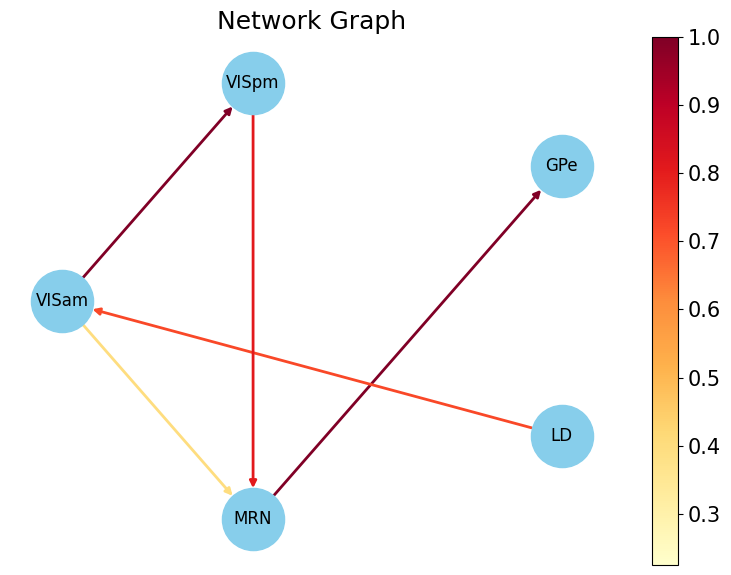

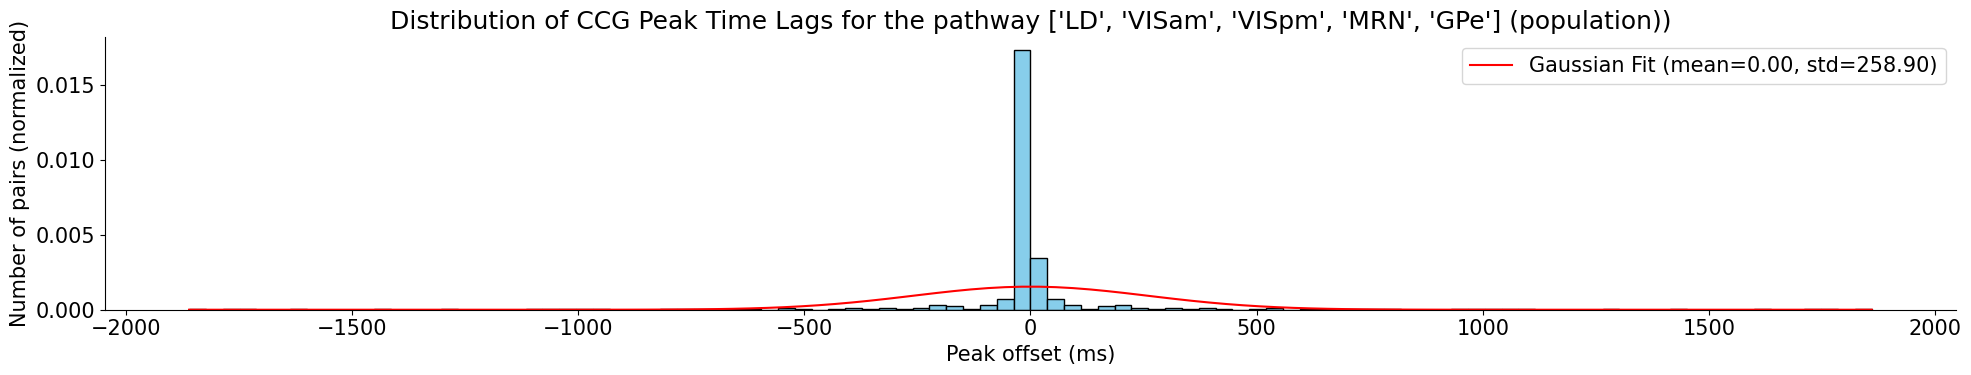

The sequence is: ['MOs', 'ACA', 'VISam', 'VISpm']


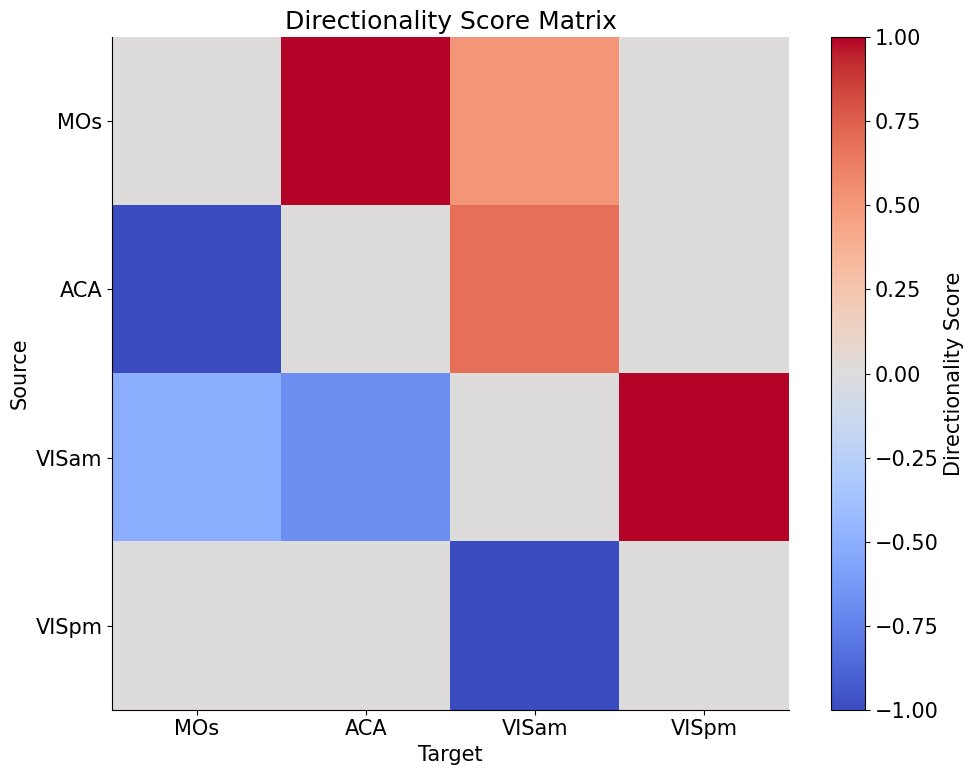

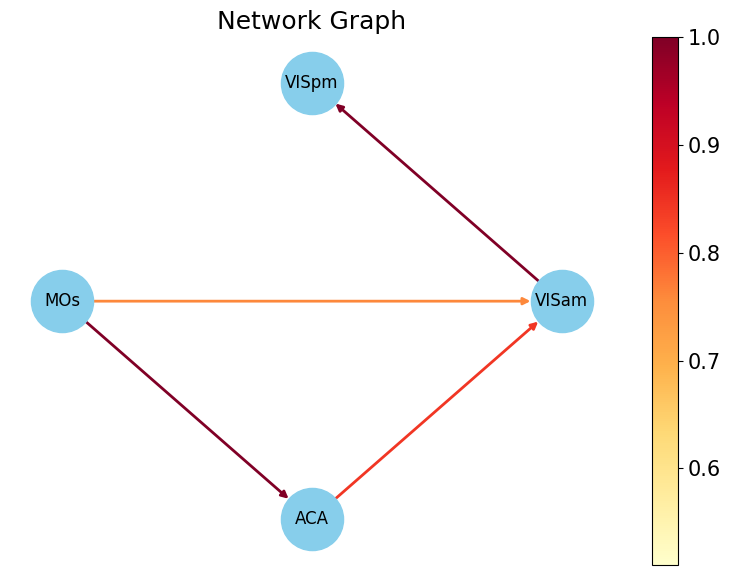

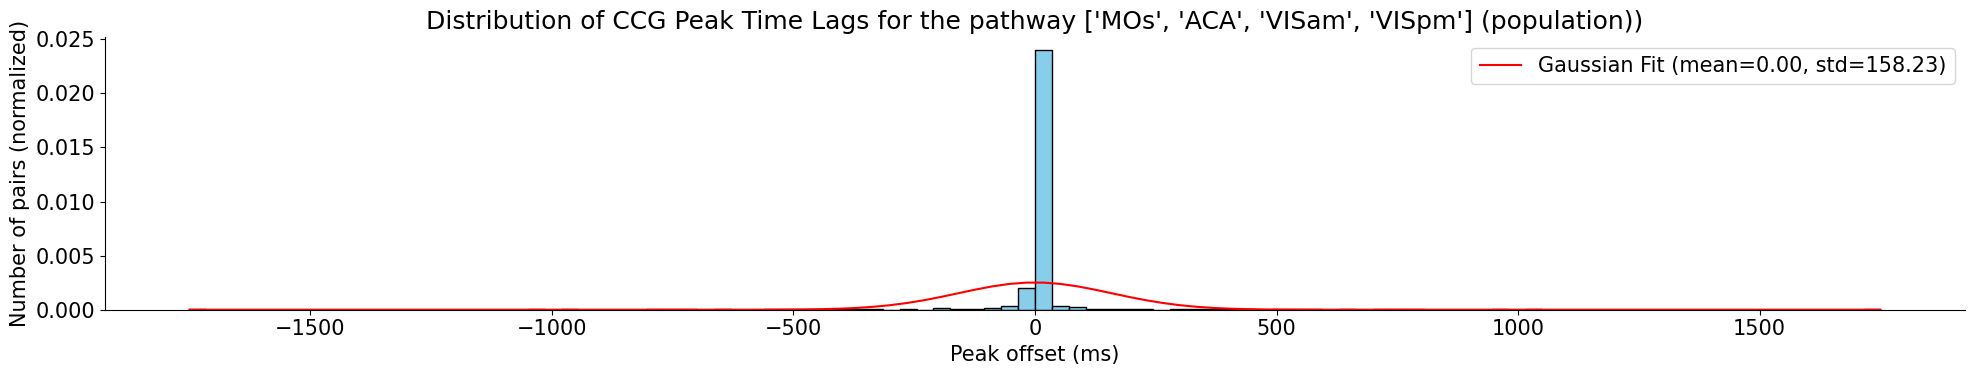

The sequence is: ['MOs', 'ACA', 'VISam', 'VISpm', 'VISrl']


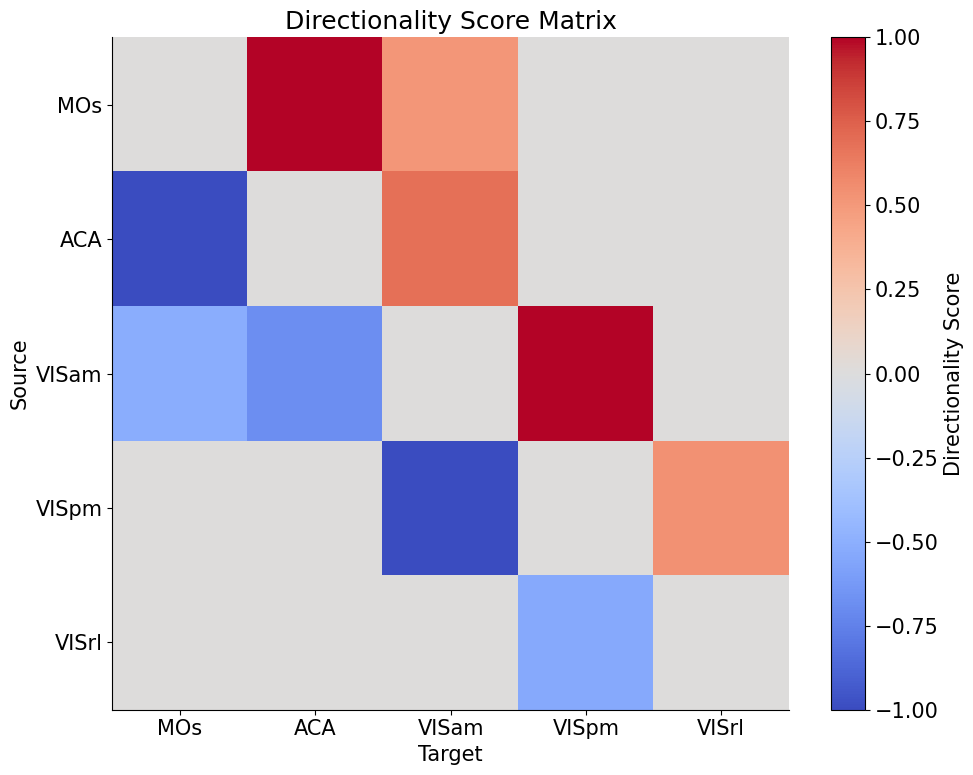

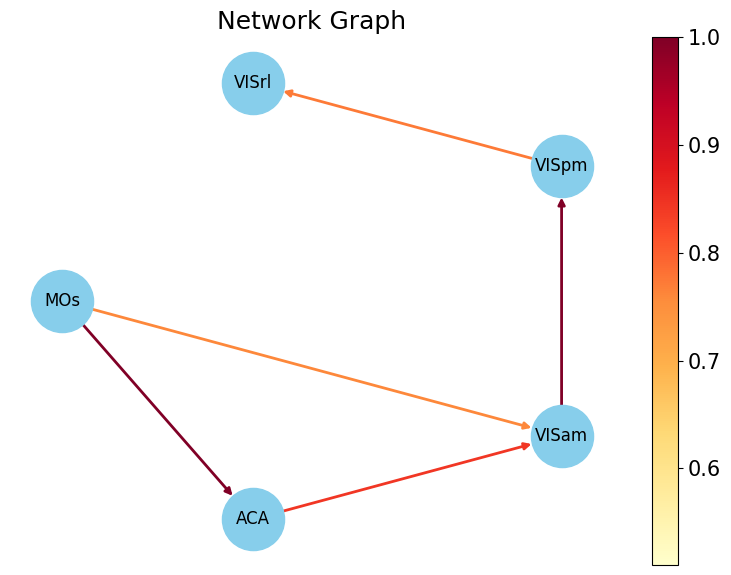

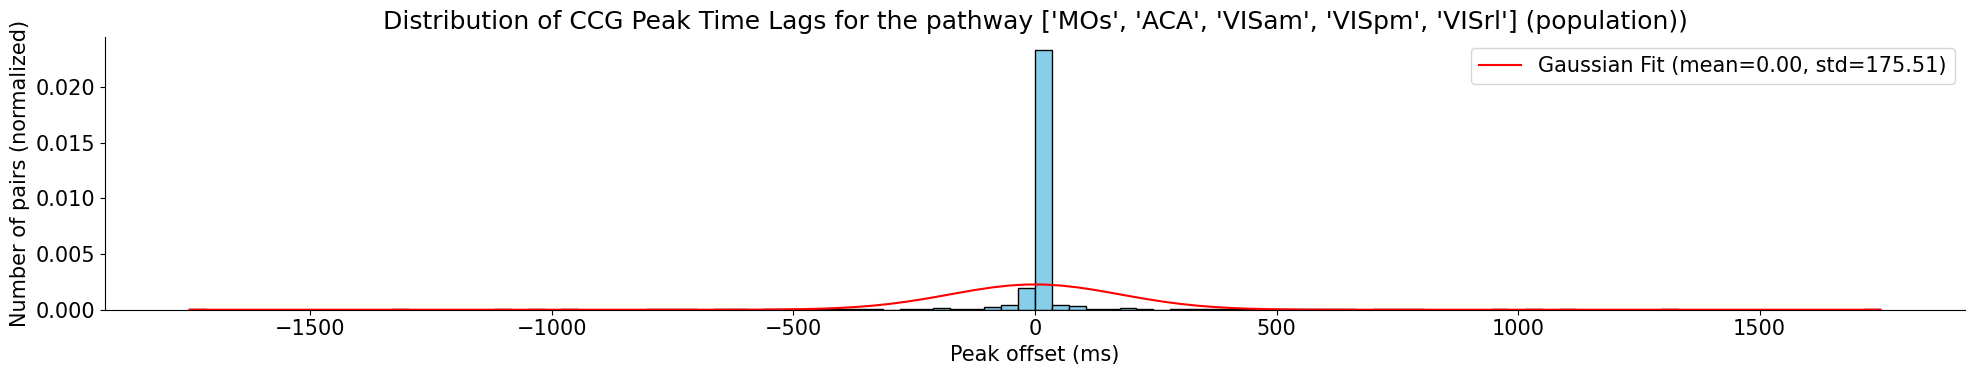

The sequence is: ['MOs', 'ACA', 'VISam', 'VISpm', 'MRN']


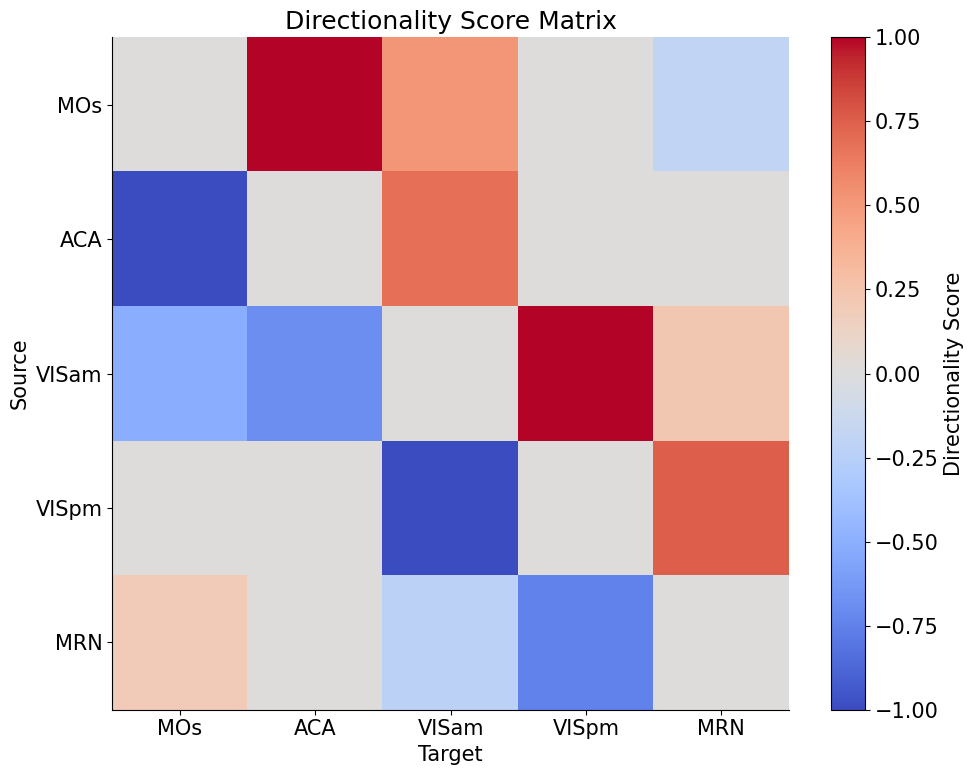

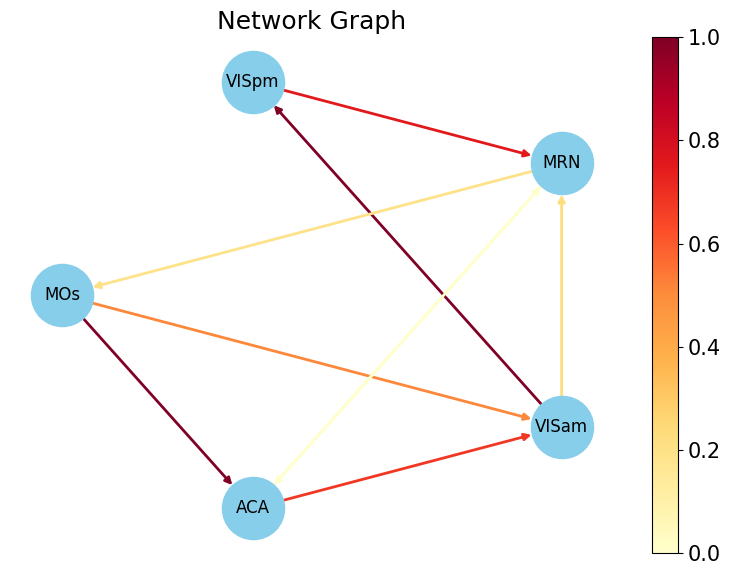

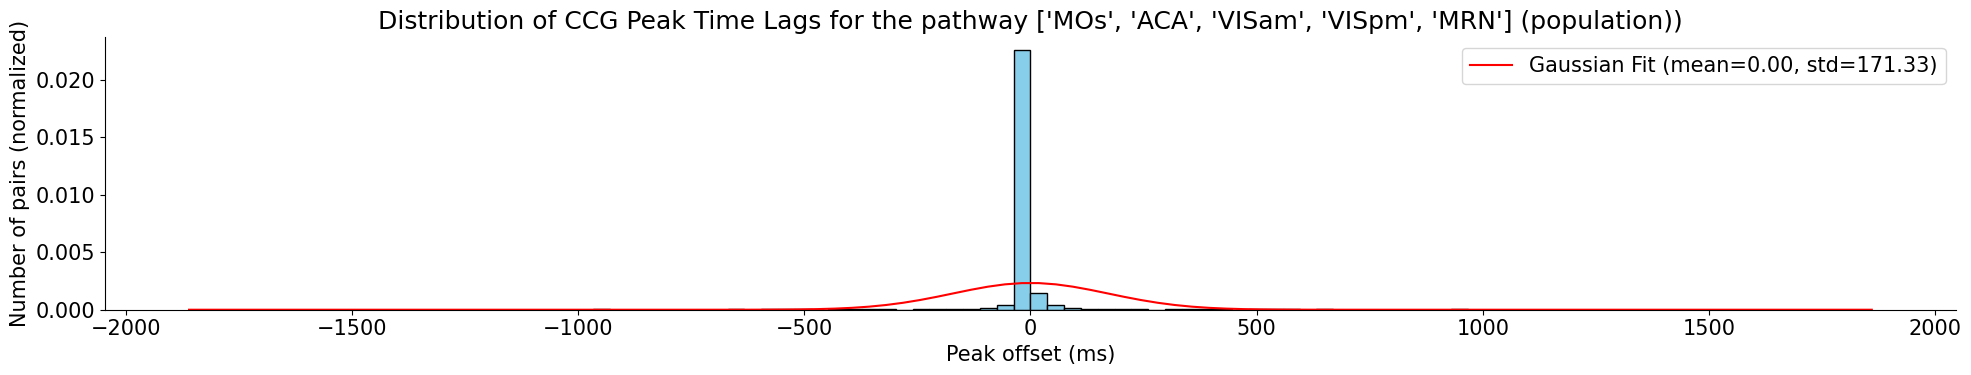

The sequence is: ['MOs', 'ACA', 'VISam', 'VISpm', 'MRN', 'GPe']


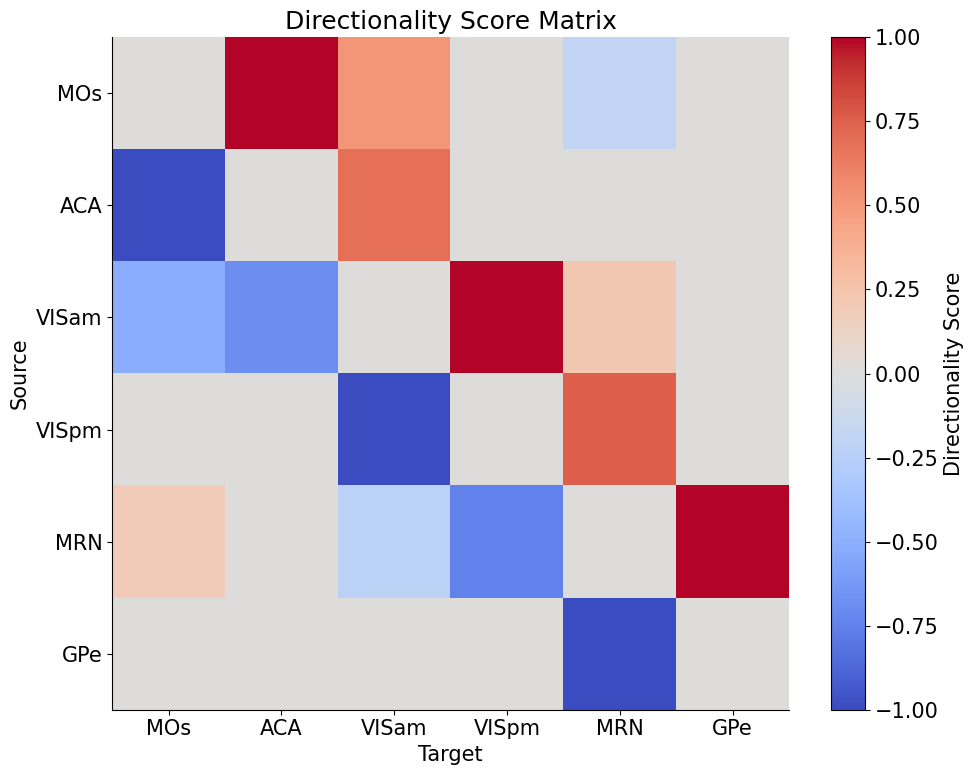

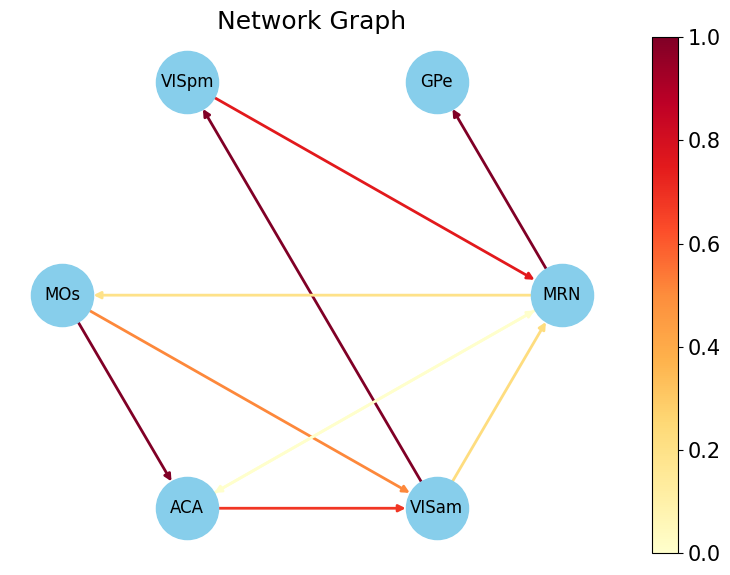

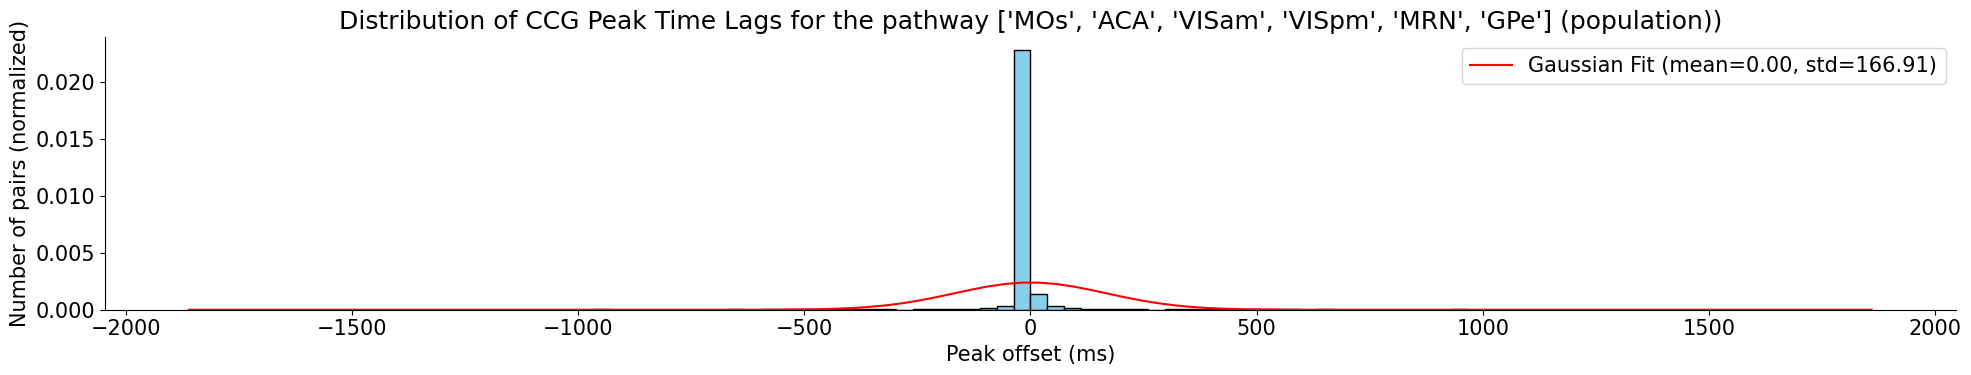

The sequence is: ['MOs', 'ACA', 'SCs']


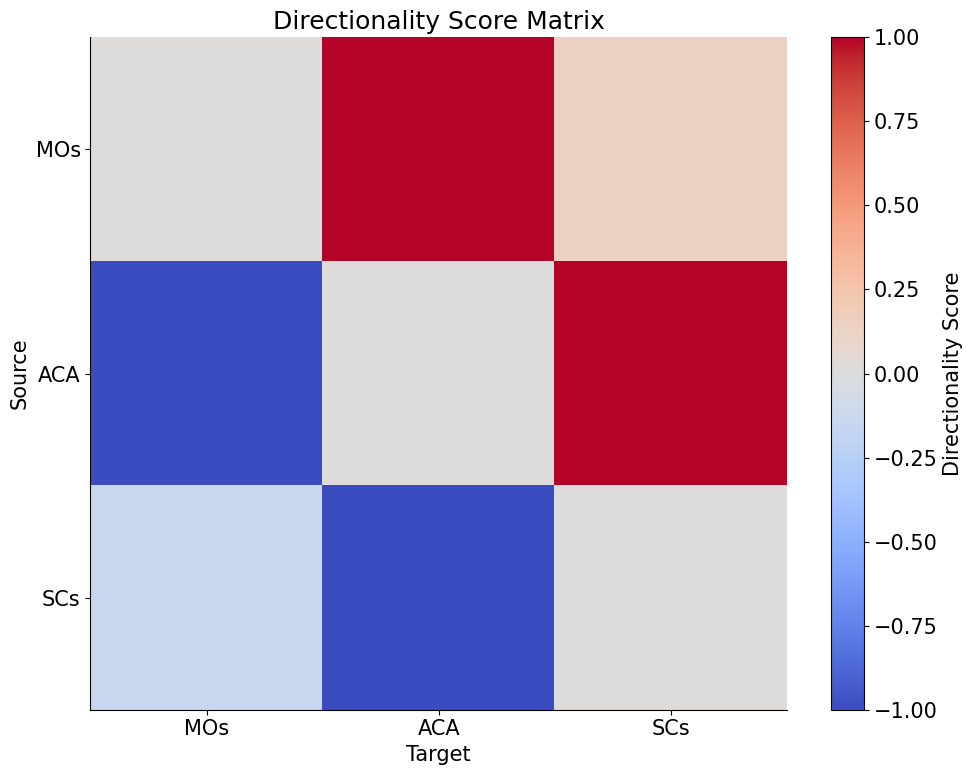

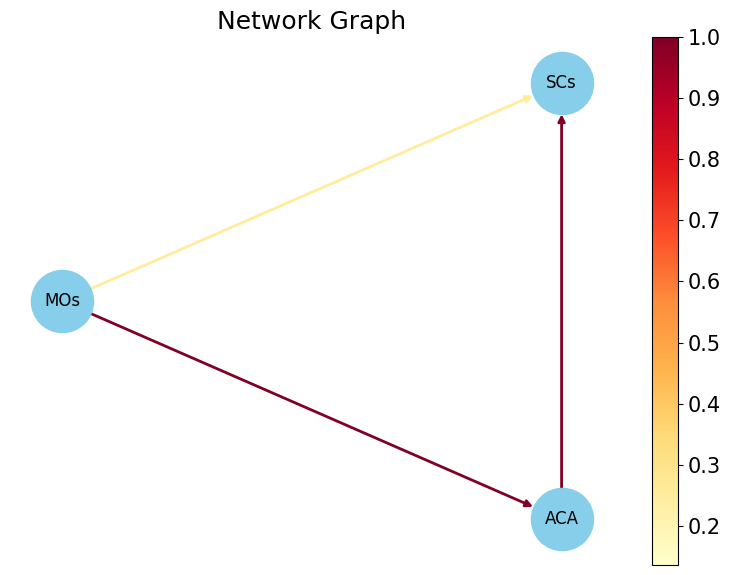

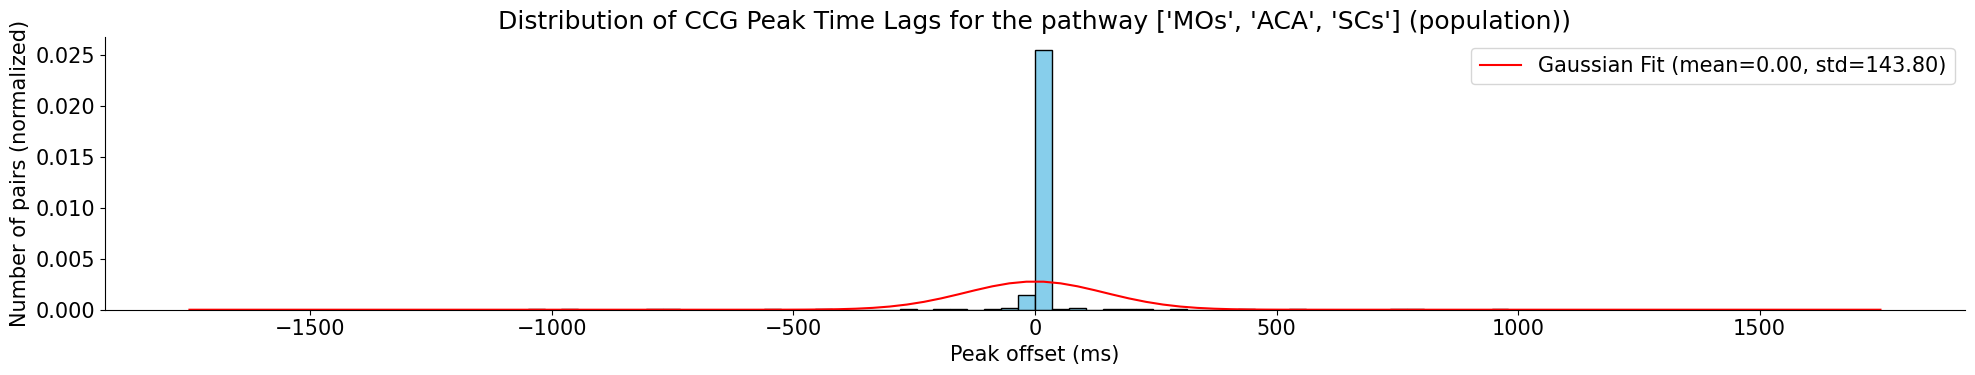

The sequence is: ['MOs', 'PL', 'SCs']


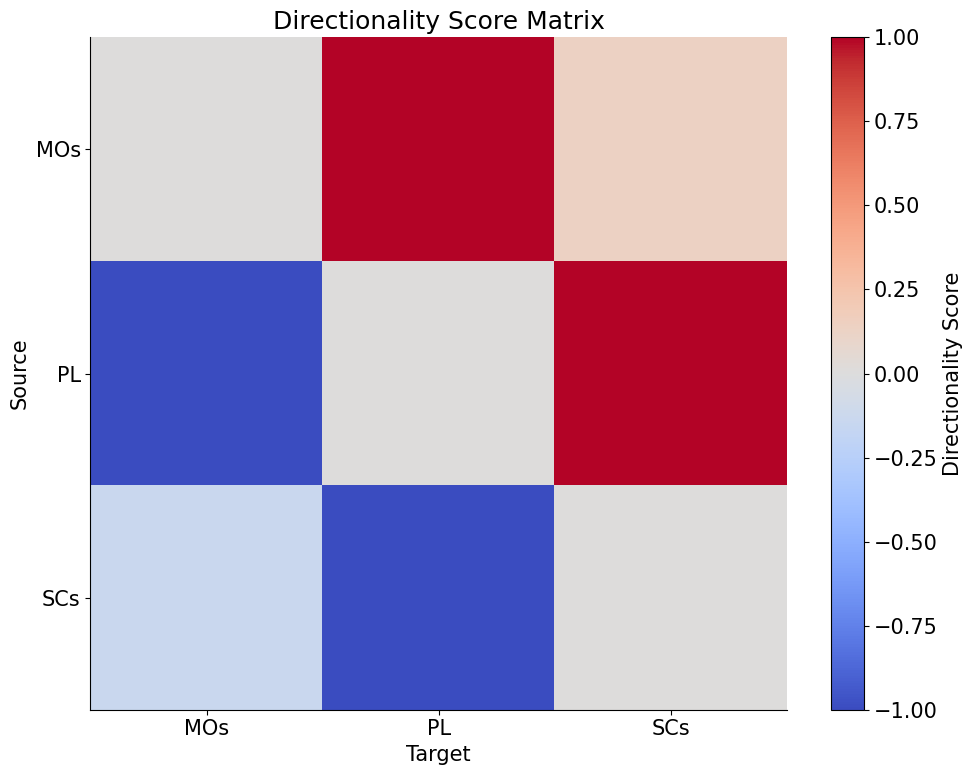

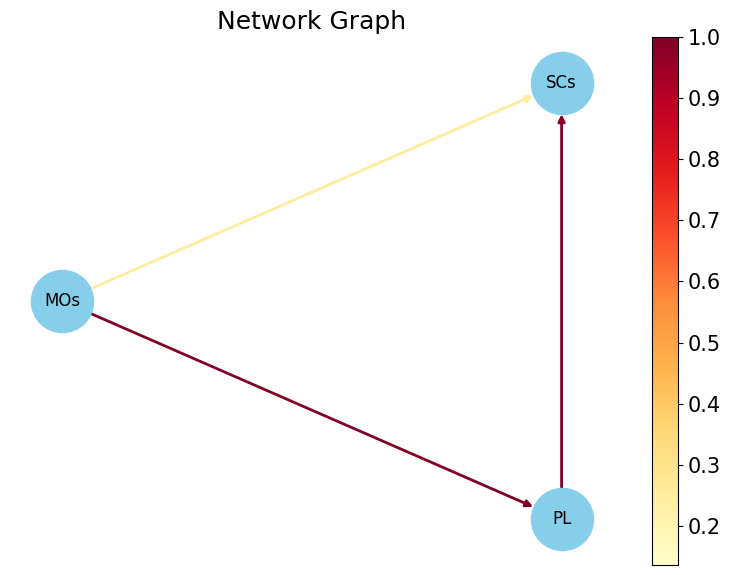

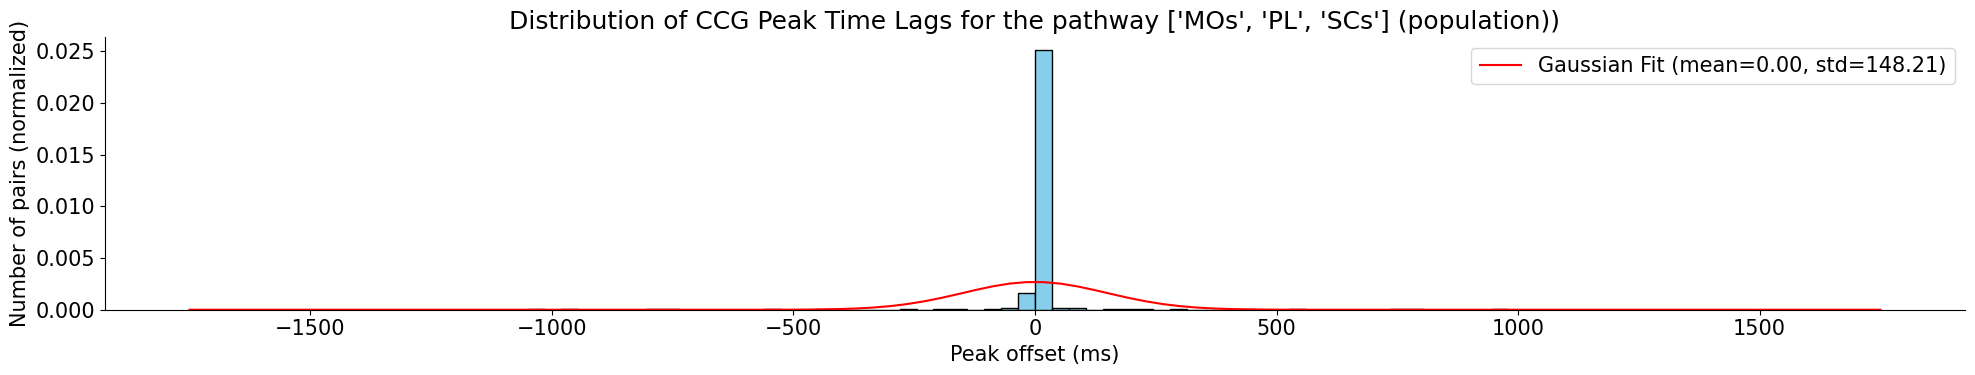

The sequence is: ['MOs', 'VISam', 'VISpm', 'VISrl']


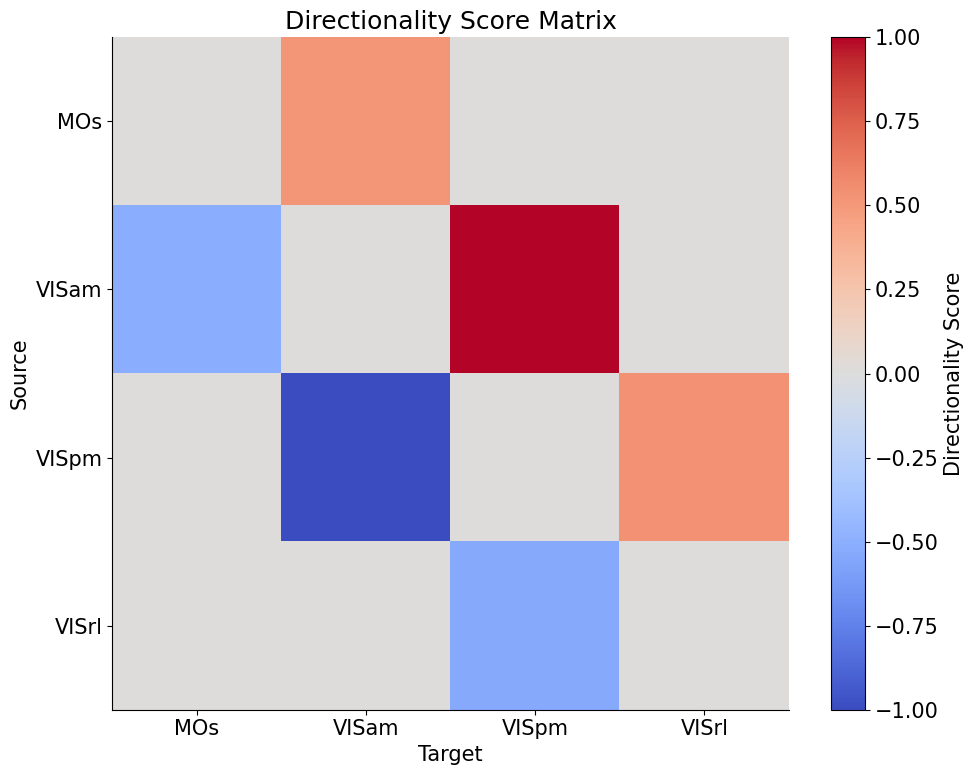

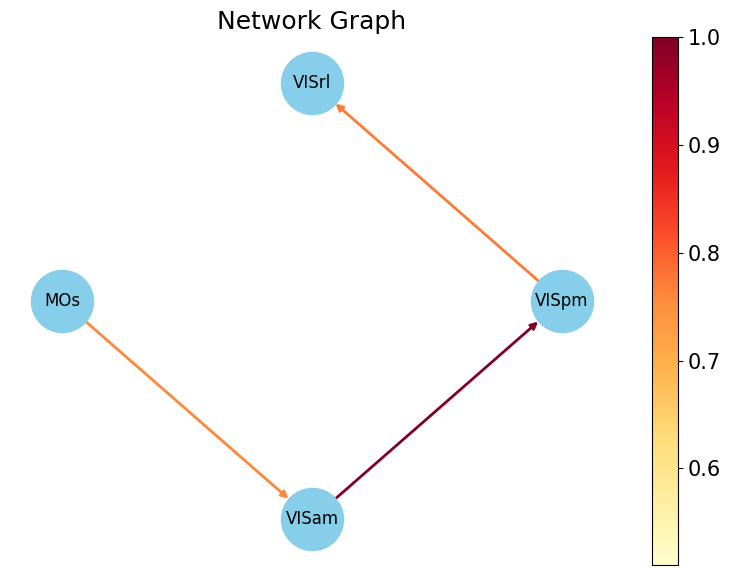

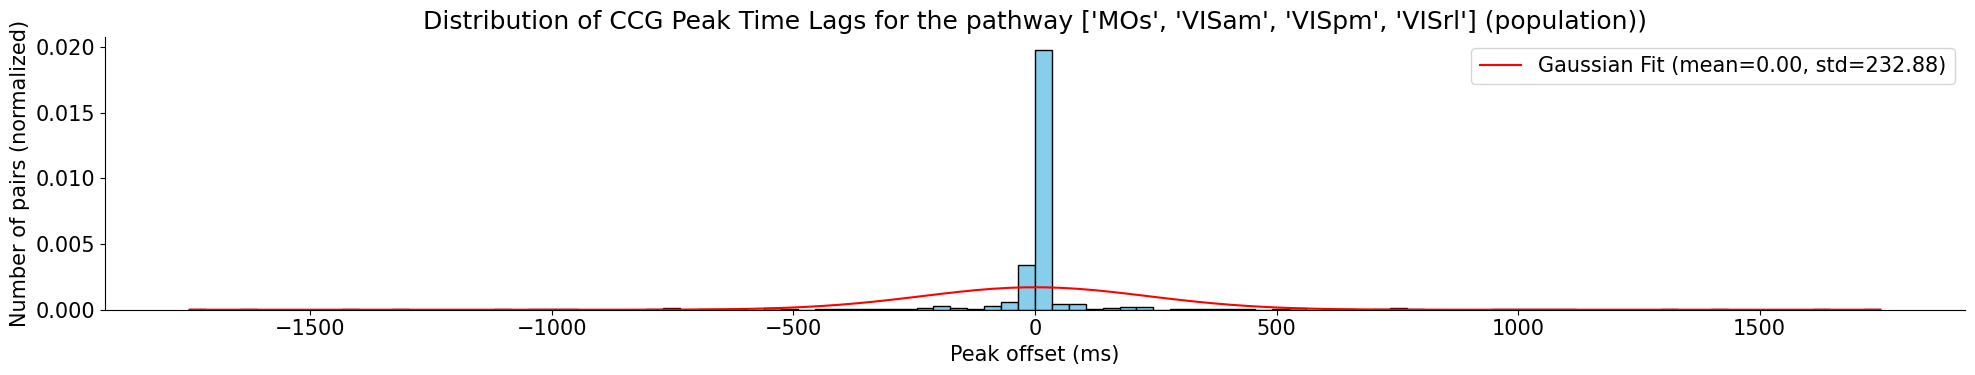

The sequence is: ['MOs', 'VISam', 'VISpm', 'MRN']


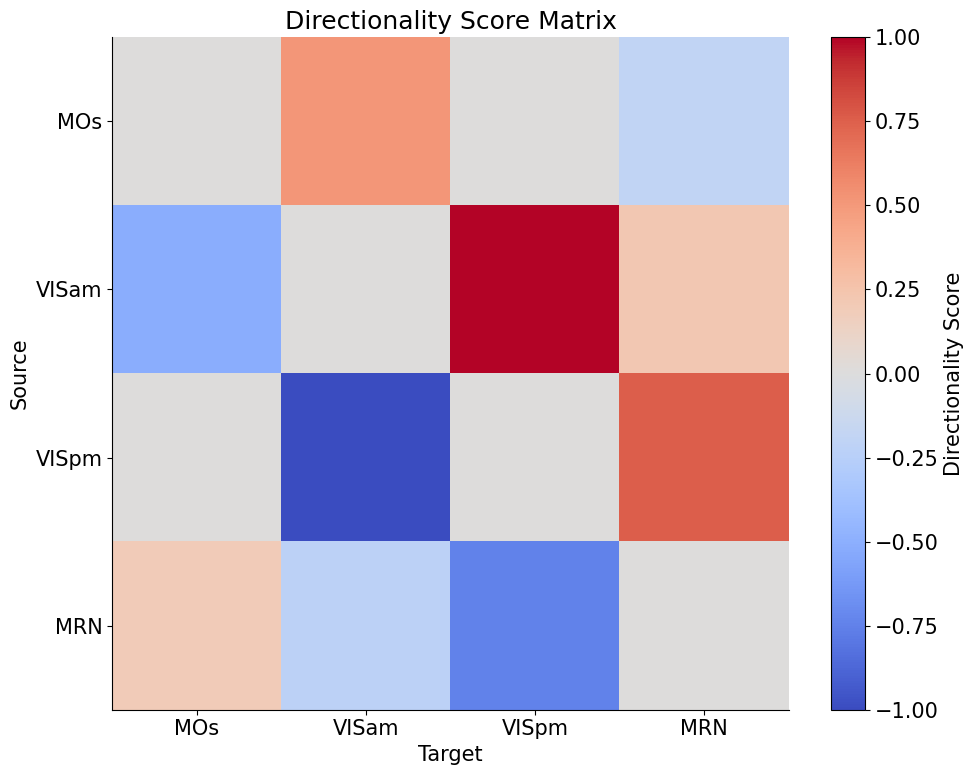

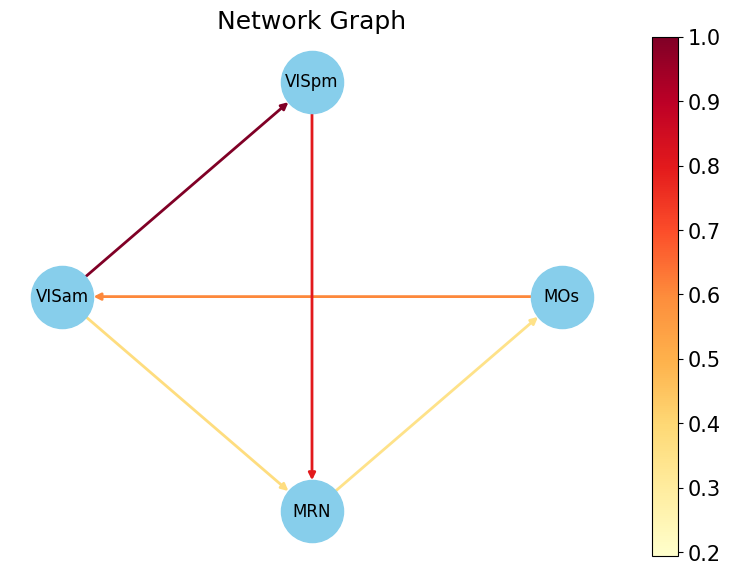

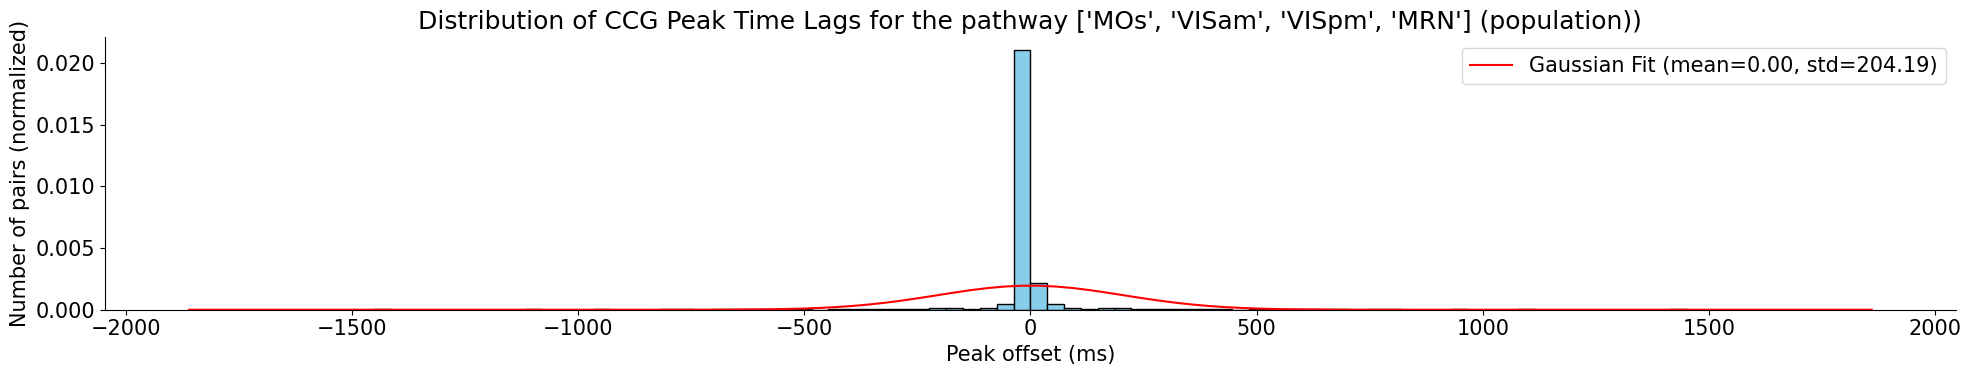

The sequence is: ['MOs', 'VISam', 'VISpm', 'MRN', 'GPe']


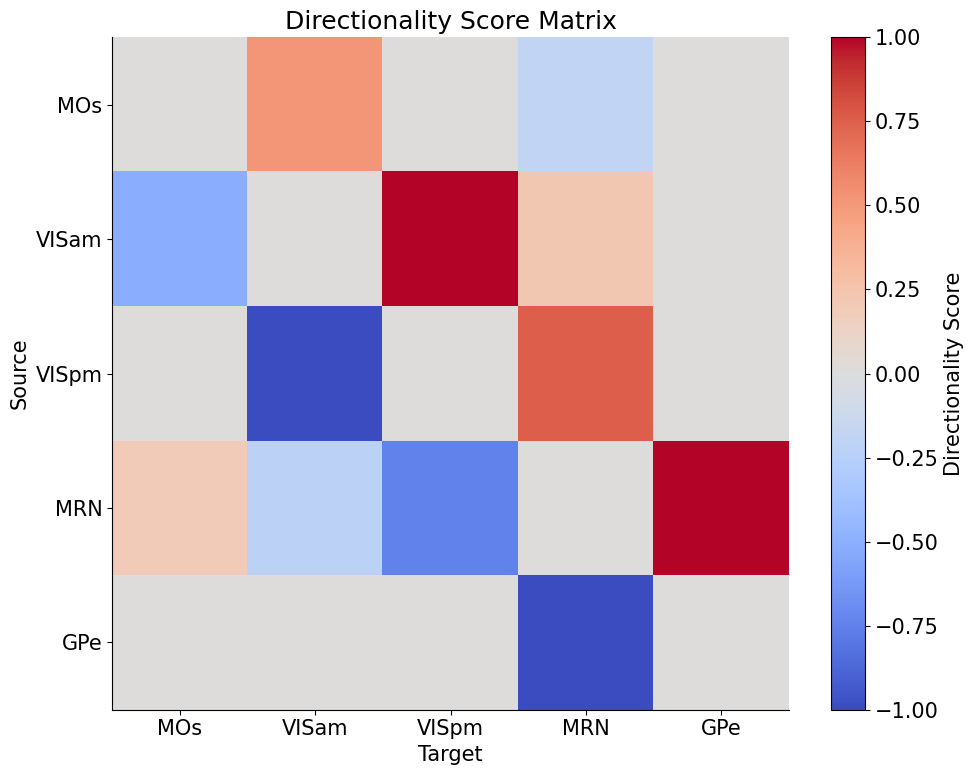

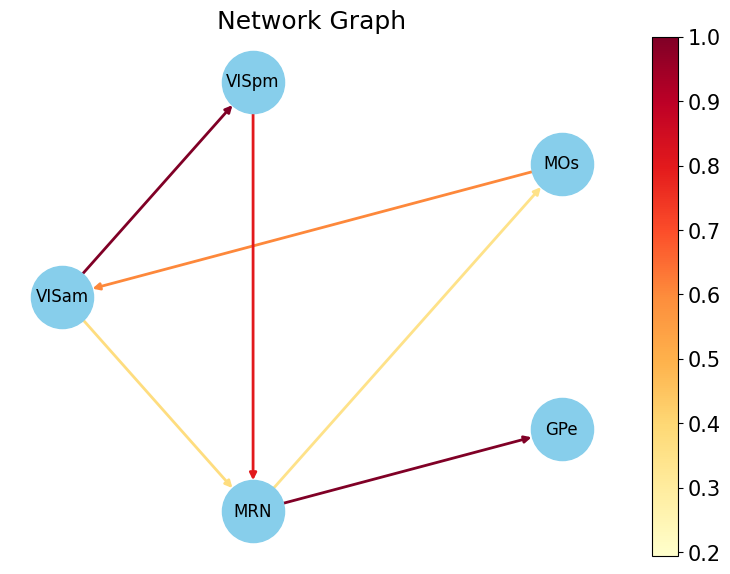

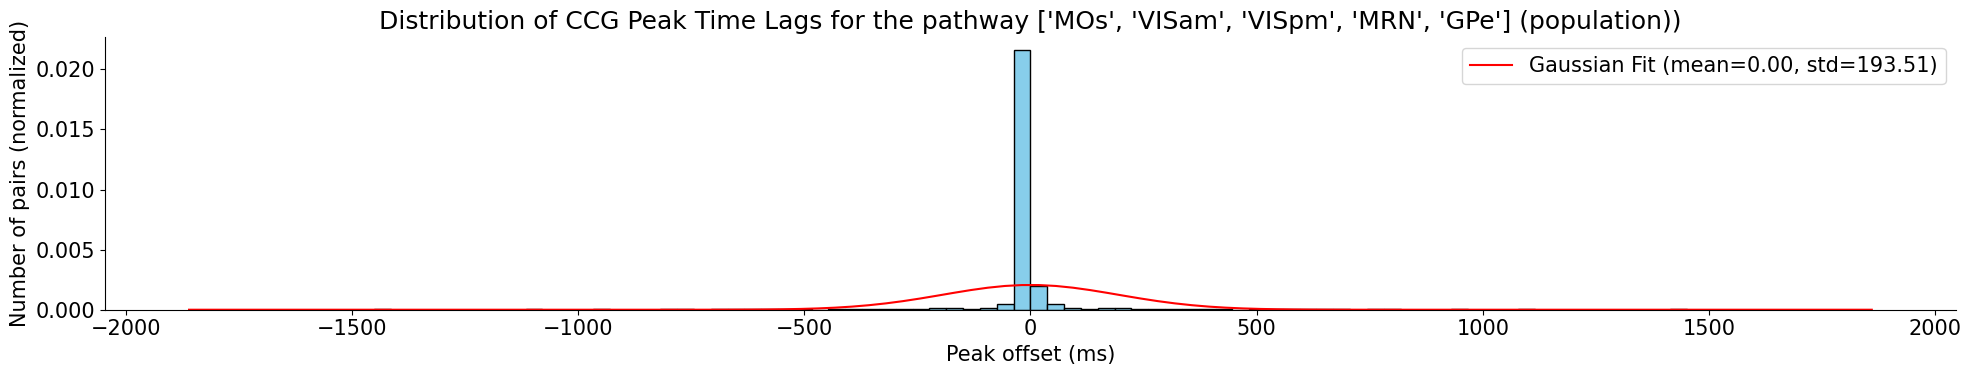

The sequence is: ['VISam', 'VISpm', 'MRN', 'GPe']


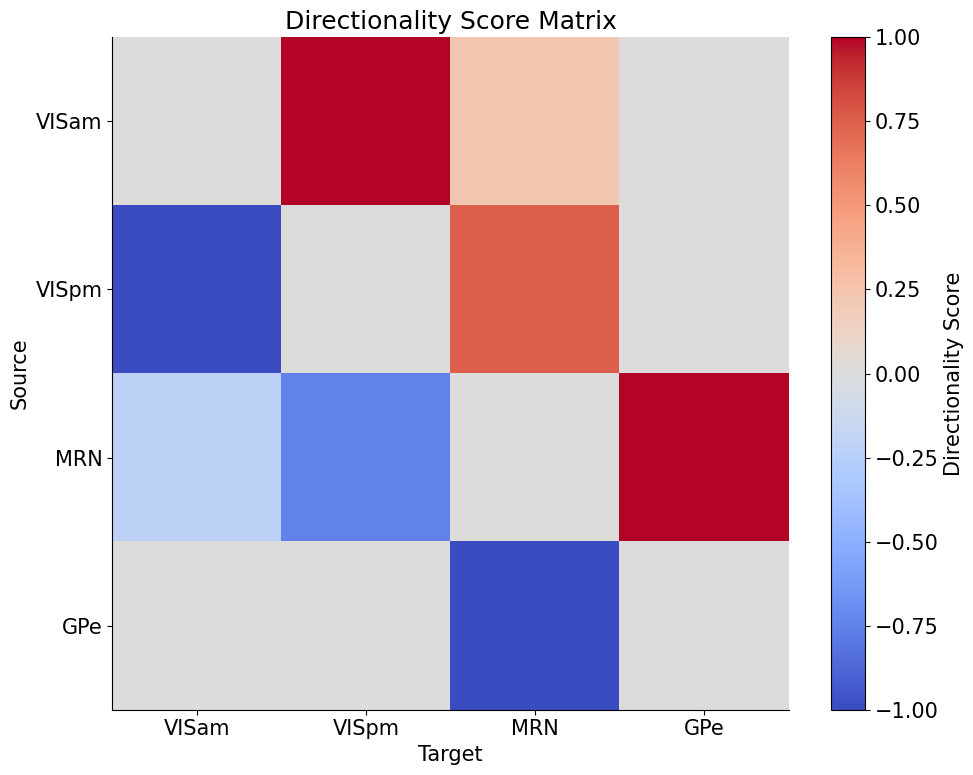

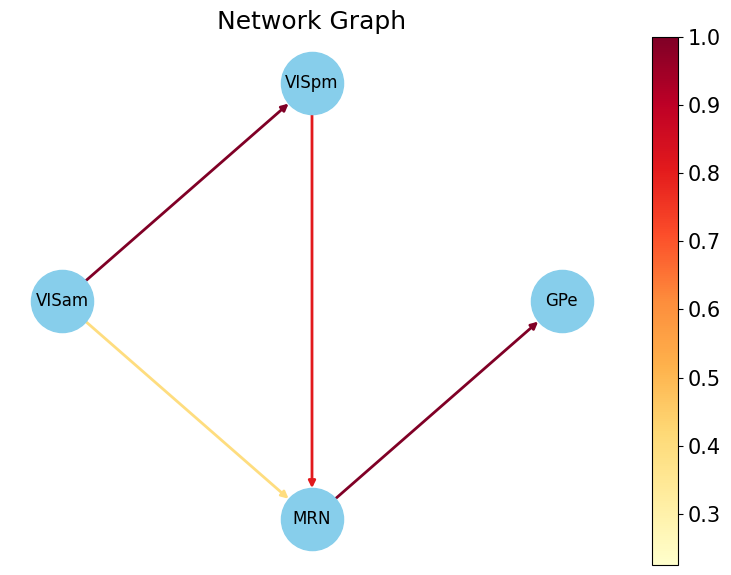

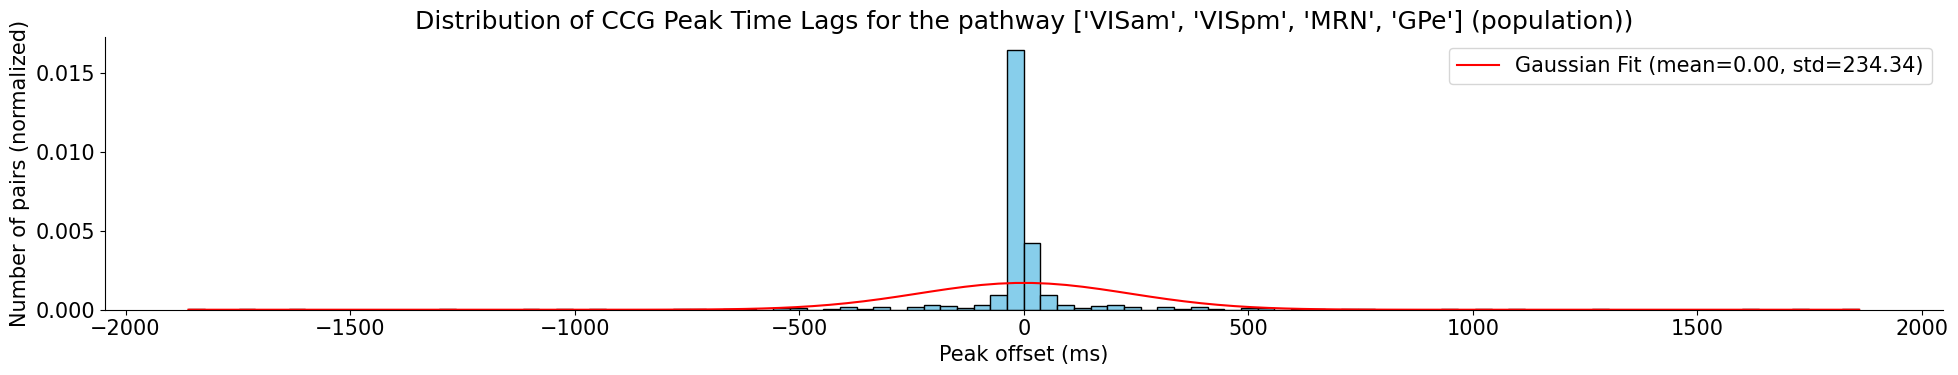

The sequence is: ['ACA', 'VISam', 'VISpm', 'VISrl']


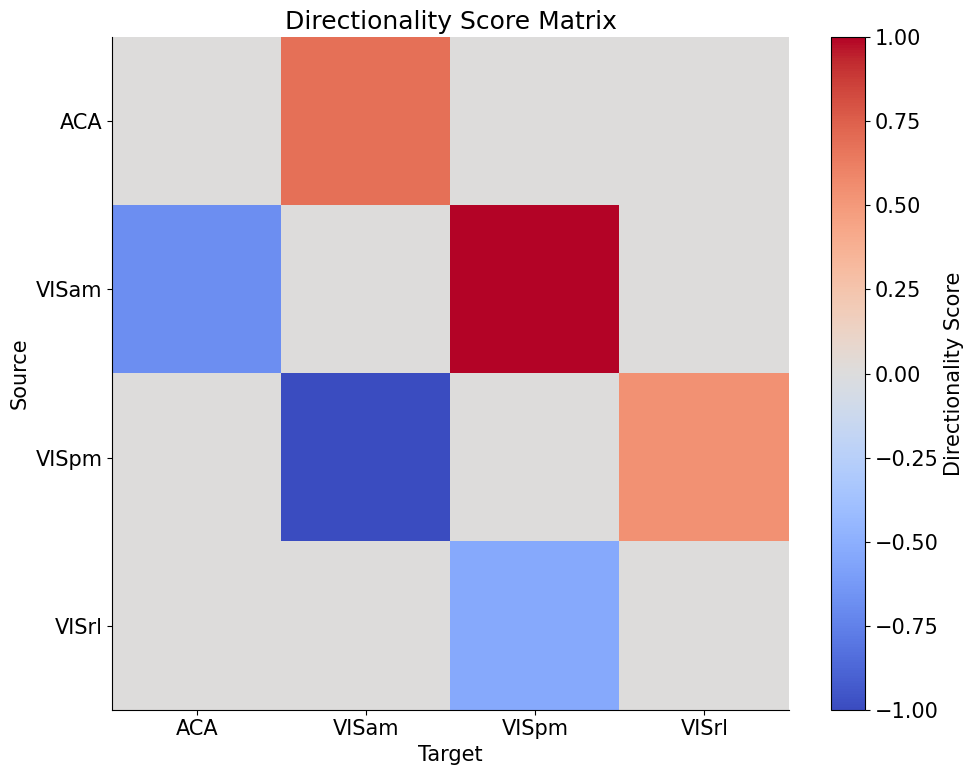

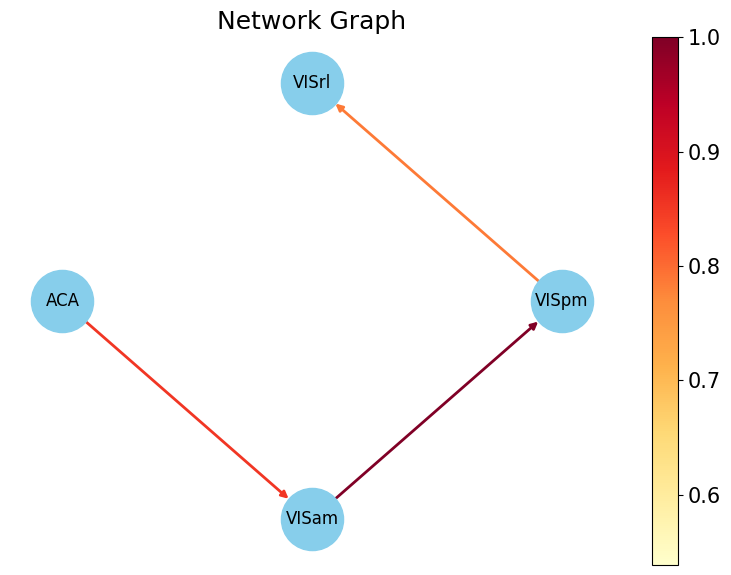

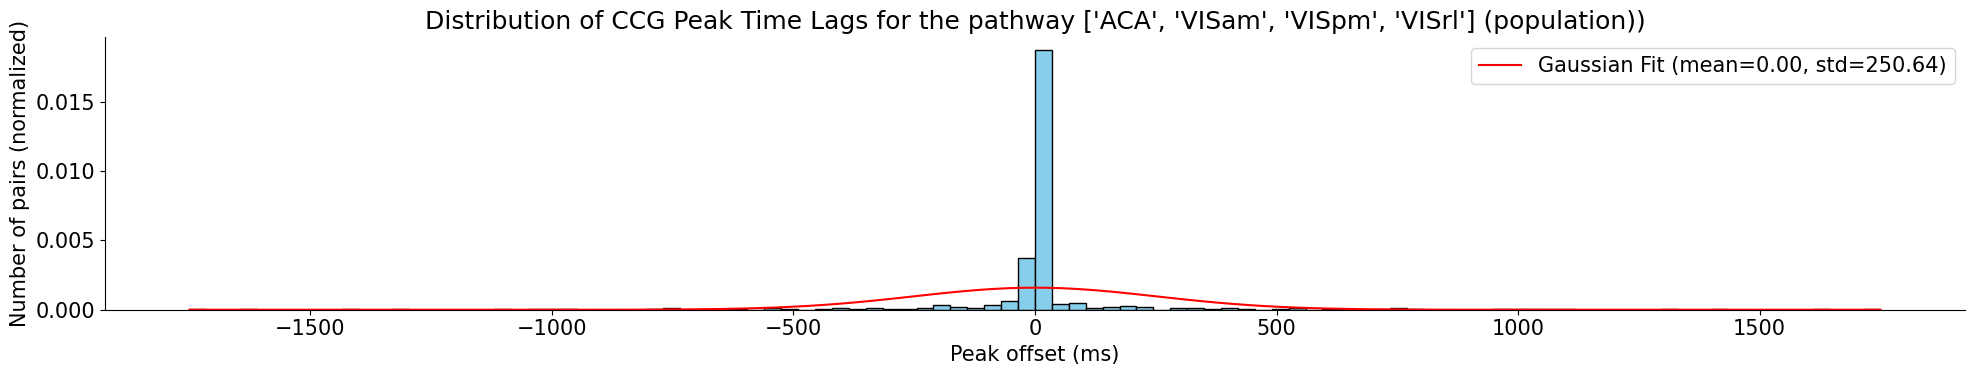

The sequence is: ['ACA', 'VISam', 'VISpm', 'MRN']


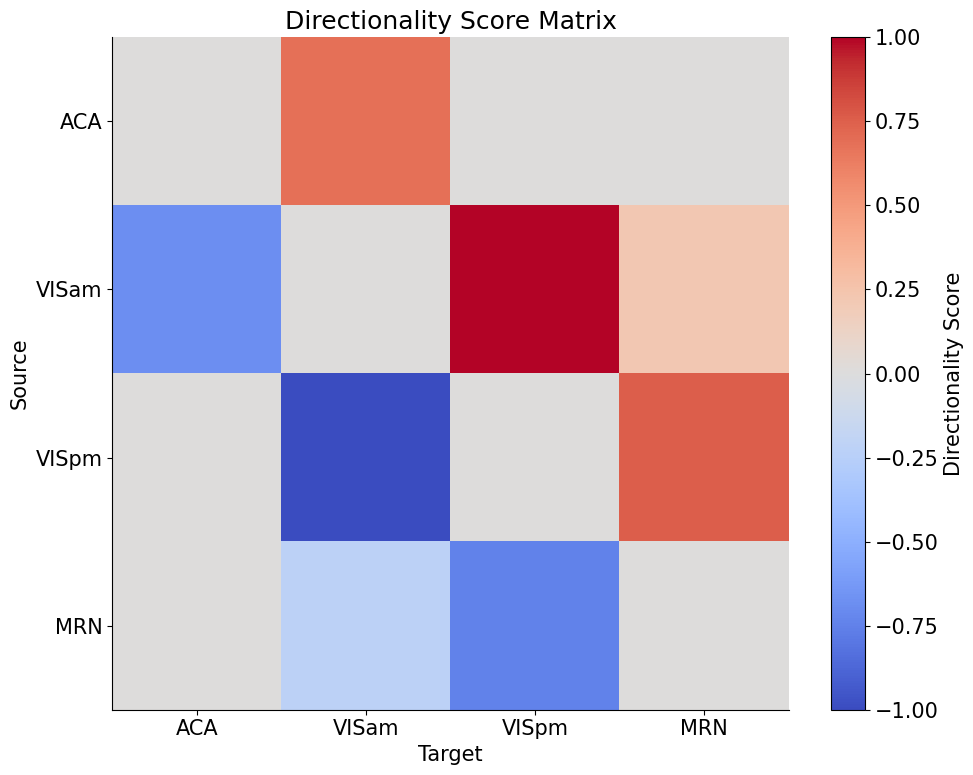

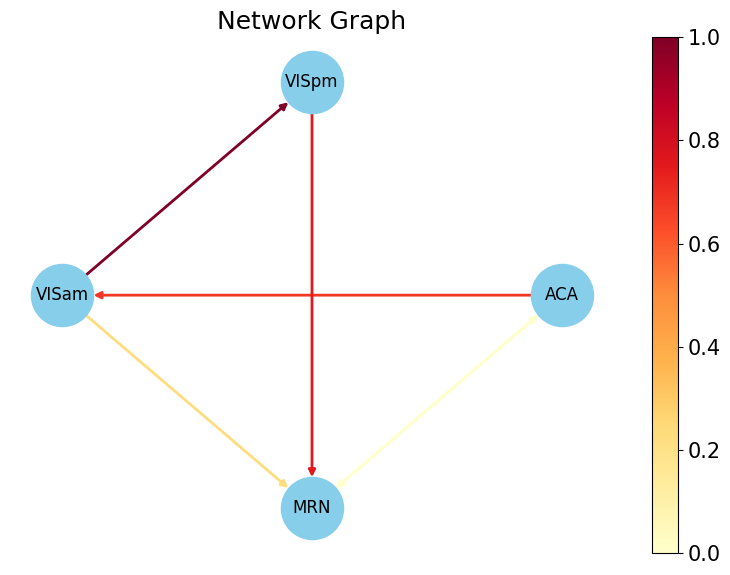

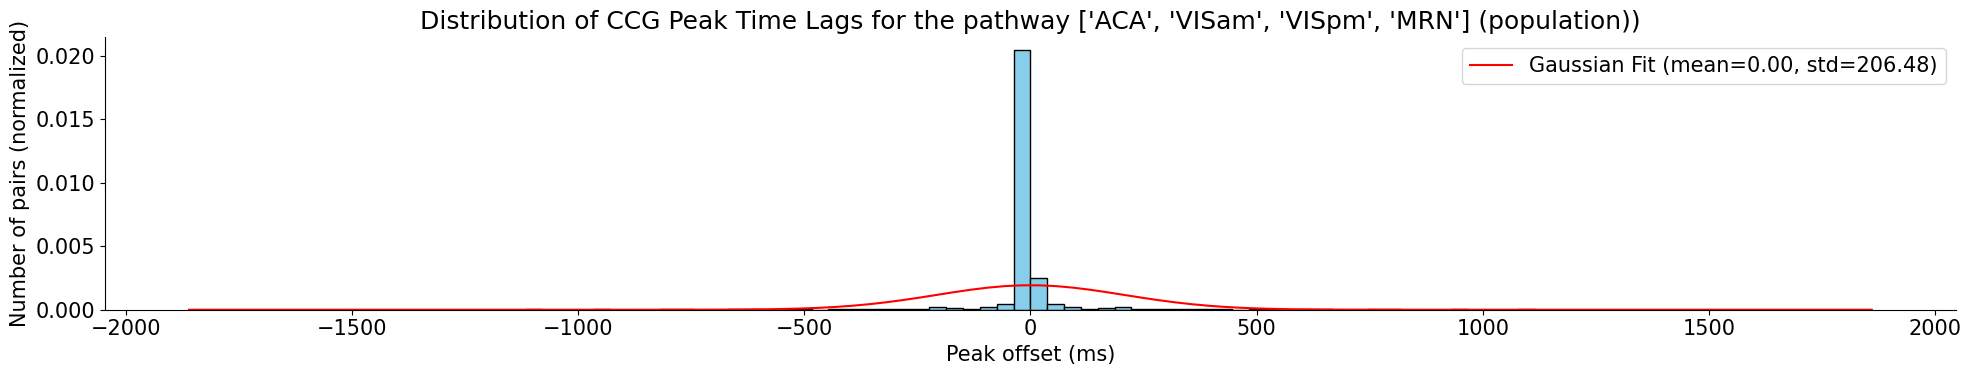

The sequence is: ['ACA', 'VISam', 'VISpm', 'MRN', 'GPe']


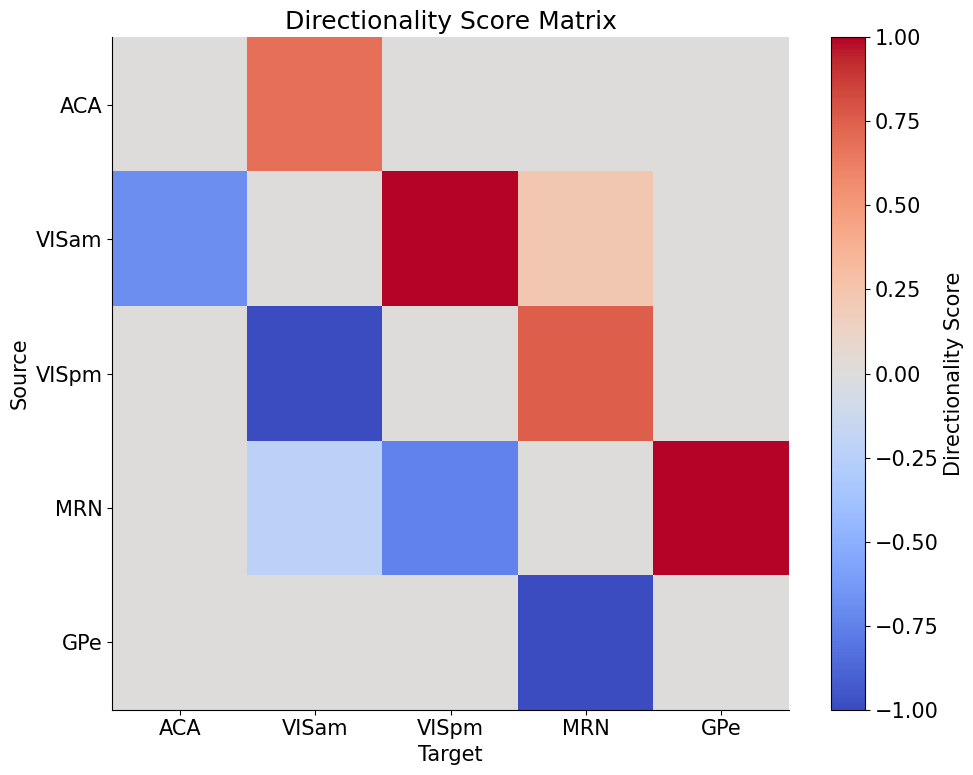

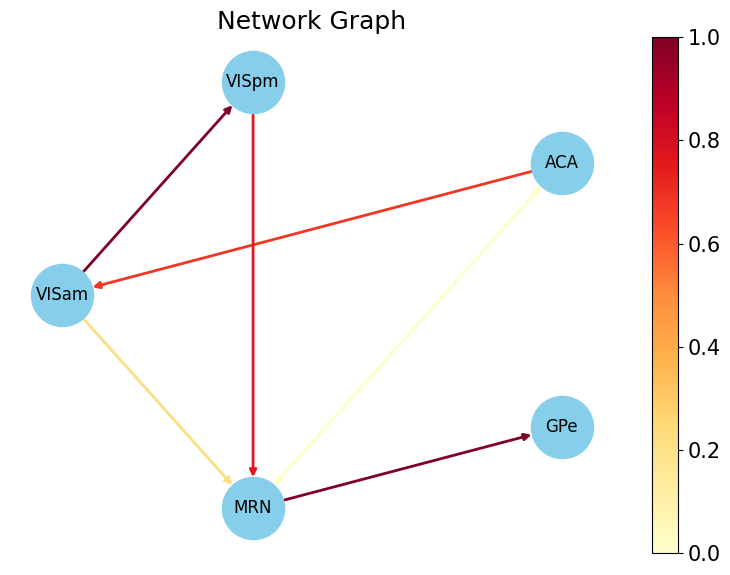

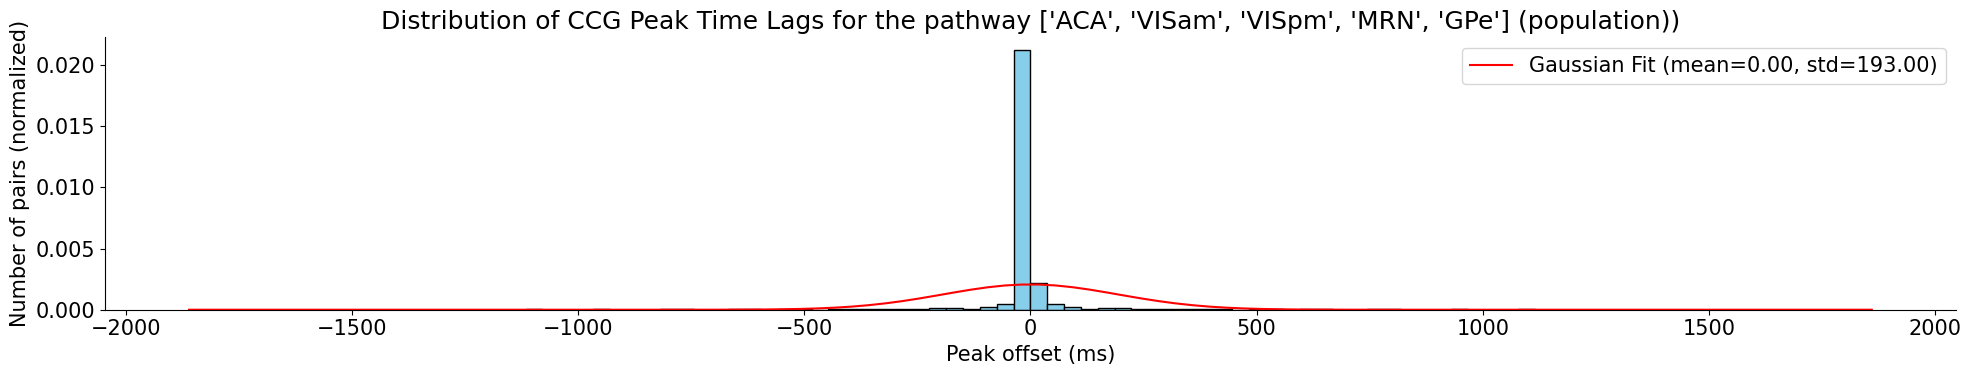

In [ ]:
# Example on population
path_threshold_value = 2
edge_threshold_value = .5
onset = 700
trial = 'correct'

# population_pathways, population_directions = find_pathway_population(path_threshold_value, edge_threshold_value, onset, trial, file_path)
# print("The number of population pathways:", len(population_pathways))
population_directions = compute_directionality_score_for_population(onset_time=700, outcome_trial='correct')


# Plot the DS matrix and network for all path ways
for k in range(len(filtered_paths)):
    sequence = filtered_paths[k][0]
    print("The sequence is:", sequence)
    plot_directionality_score_matrix(results_directionality_score=population_directions, sequence=sequence)
    filtered_sequence_direction = {pair: value for pair, value in population_directions.items() if all(area in sequence for area in pair)}
    plot_network(filtered_sequence_direction)
    plot_CCG_peak_for_population(sequence=sequence)


Brain area connections:  1418
All paths exceeding the path threshold of 3 and edge threshold of 0.6:
['TH', 'LD', 'CP', 'PT']: 3.0
['TH', 'LD', 'CP', 'VPM']: 3.0
['TH', 'LD', 'CP', 'VPM', 'VISa']: 3.6
['EP', 'SNr', 'CP', 'PT']: 3.0
['EP', 'SNr', 'CP', 'VPM']: 3.0
['EP', 'SNr', 'CP', 'VPM', 'VISa']: 3.6
['EP', 'ZI', 'MS', 'MOs']: 3.0
['OT', 'SNr', 'CP', 'PT']: 3.0
['OT', 'SNr', 'CP', 'VPM']: 3.0
['OT', 'SNr', 'CP', 'VPM', 'VISa']: 3.6
['OT', 'TH', 'LD', 'CP']: 3.0
['OT', 'TH', 'LD', 'CP', 'PT']: 4.0
['OT', 'TH', 'LD', 'CP', 'VPM']: 4.0
['OT', 'TH', 'LD', 'CP', 'VPM', 'VISa']: 4.6
['OT', 'TH', 'LD', 'EPd']: 3.0
['OT', 'TH', 'LD', 'SSp', 'AUD']: 3.7333333333333334
['OT', 'TH', 'LD', 'ACA']: 3.0
['OT', 'ZI', 'MS', 'MOs']: 3.0
['SUB', 'CA3', 'ILA', 'PO', 'BMA']: 3.344419807834442
['SUB', 'CA3', 'ILA', 'PO', 'COA']: 3.344419807834442
['SUB', 'CA3', 'MB', 'SSp', 'AUD']: 3.506324569739204
['SUB', 'CA3', 'MB', 'RSP', 'VISp']: 3.3619636674835647
['SUB', 'CA3', 'MB', 'RSP', 'IC']: 3.6777531411677

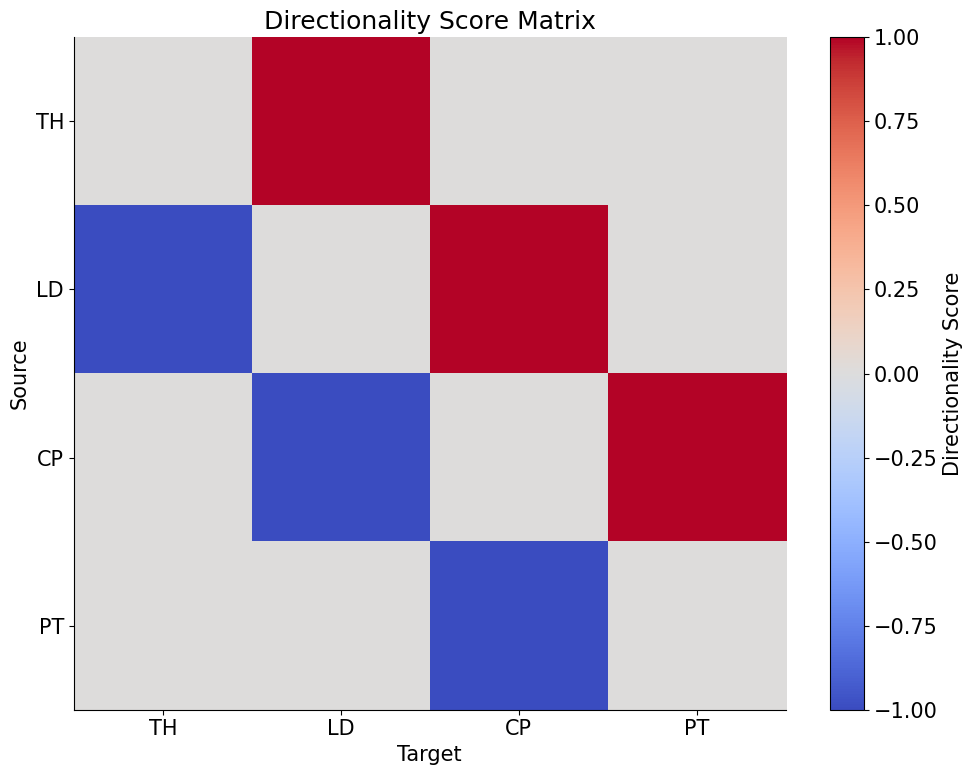

<ipython-input-20-e931bd5046a2>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, orientation="vertical")


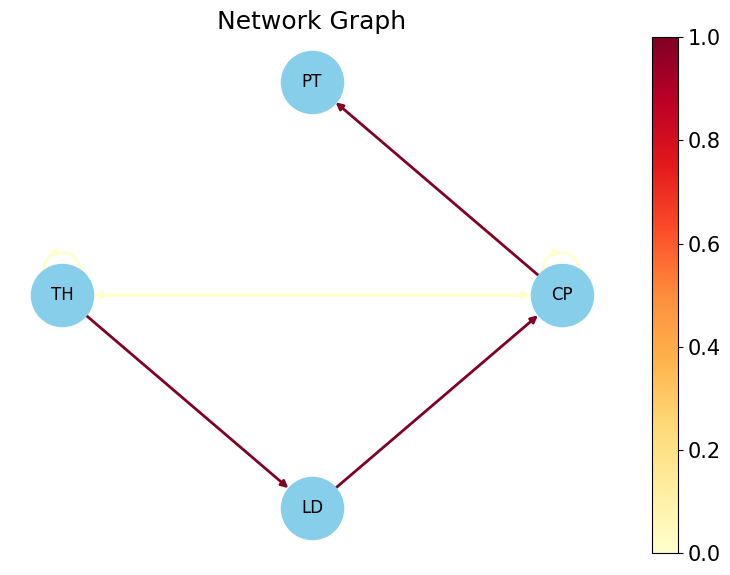

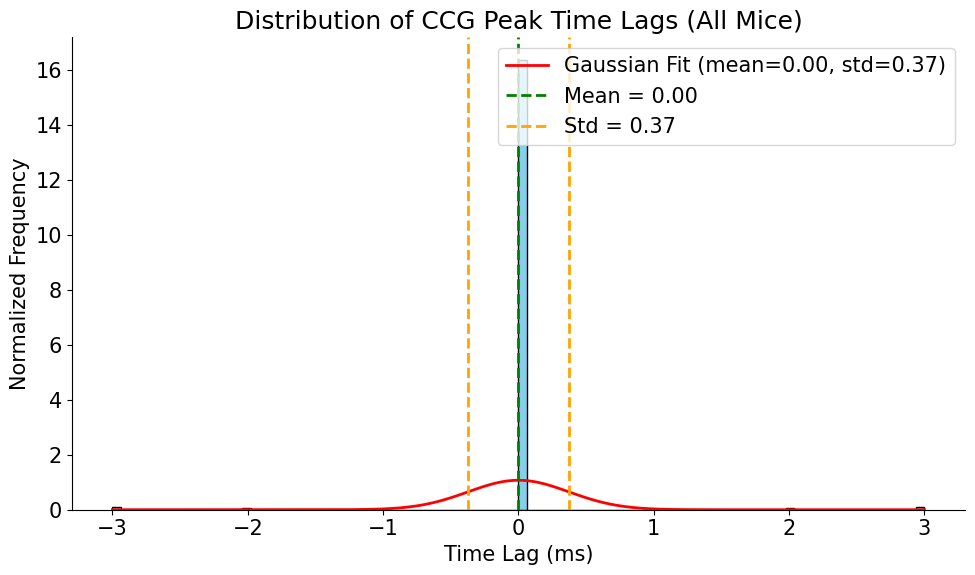

({},
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, -3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       

In [ ]:
# Example on population
path_threshold_value = 3
edge_threshold_value = .6
onset = 1000
trial = 'miss'

population_pathways, population_directions = find_pathway_population(path_threshold_value, edge_threshold_value, onset, trial)
print("The number of population pathways:", len(population_pathways))

# Extract the specific pathways from pathways
brain_areas = []
for brain_areas_list, value in population_pathways:
    brain_areas.extend(brain_areas_list)
brain_areas = set(brain_areas)


# Plot the DS matrix and network for all path ways
# for k in range(len(population_pathways)):
k = 0 # the k-th pathway
sequence = population_pathways[k][0]
print("The sequence is:", sequence)
filtered_sequence_direction = {pair: value for pair, value in population_directions.items() if all(area in sequence for area in pair)}
plot_directionality_score_matrix(results_directionality_score=filtered_sequence_direction, sequence=sequence)
plot_network(filtered_sequence_direction)
plot_CCG_peak_for_population(sequence=sequence)
